In [31]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr


def moe_correct_ridge(Z_orig, Z_cos, Z_corr, R, W, K, Phi_Rk, Phi_moe, lamb):
    Z_corr = Z_orig.copy()
    for i in range(K):
        Phi_Rk = np.multiply(Phi_moe, R[i,:])
        x = np.dot(Phi_Rk, Phi_moe.T) + lamb
        W = np.dot(np.dot(np.linalg.inv(x), Phi_Rk), Z_orig.T)
        W[0,:] = 0 # do not remove the intercept
        Z_corr -= np.dot(W.T, Phi_Rk)
    Z_cos = Z_corr / np.linalg.norm(Z_corr, ord=2, axis=0)
    return Z_cos, Z_corr, W, Phi_Rk


def get_cnmf_results(name, cnmfdir, K, ldthresh):
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (K, str(ldthresh).replace('.', '_'))
    usagefn = cnmf_obj.paths['consensus_usages__txt'] % (K, str(ldthresh).replace('.', '_'))
    genefn = cnmf_obj.paths['nmf_genes_list']
    hvgs = open(genefn).read().split('\n')
    spectra = pd.read_csv(scorefn, sep='\t', index_col=0).T
    usage = pd.read_csv(usagefn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)

    orig = np.array(usage.sum(axis=0).sort_values(ascending=False).index)
    remap = dict(zip(orig, np.arange(len(orig))))

    usage = usage.rename(columns=remap).sort_index(axis=1)

    spectra.columns = [str(x) for x in spectra.columns]
    spectra = spectra.rename(columns=remap).sort_index(axis=1)
    
    top_genes = []
    ngenes = 100
    for gep in spectra.columns:
        top_genes.append(list(spectra.sort_values(by=gep, ascending=False).index[:ngenes]))
        
    
    top_genes = pd.DataFrame(top_genes, index=['GEP%d' % i for i in spectra.columns]).T
    return(usage, spectra, hvgs, top_genes, remap)


def df_col_corr(X, Y):
    X_norm = X.subtract(X.mean(axis=0), axis=1)
    X_norm= X_norm.divide(X_norm.std(axis=0), axis=1)
    Y_norm = Y.subtract(Y.mean(axis=0), axis=1)
    Y_norm= Y_norm.divide(Y_norm.std(axis=0), axis=1)
    
    X_mask = np.ma.array(X_norm.values, mask=np.isnan(X_norm.values))
    Y_mask = np.ma.array(Y_norm.values, mask=np.isnan(Y_norm.values))
    R = np.ma.dot(X_mask.T, Y_mask) / (X.shape[0]-1)
    
    R = pd.DataFrame(R, index=X.columns, columns=Y.columns)
    return(R)

# Dataset
 - [Paper](https://www.science.org/doi/10.1126/science.abl5197)
 - [Data](https://www.tissueimmunecellatlas.org/#datasets)

# Download raw data

In [ ]:
! wget --no-check-certificate https://cellgeni.cog.sanger.ac.uk/pan-immune/t-cells.h5ad

--2022-05-16 10:16:55--  https://cellgeni.cog.sanger.ac.uk/pan-immune/t-cells.h5ad
Resolving cellgeni.cog.sanger.ac.uk... 193.62.203.61, 193.62.203.62, 193.62.203.63
Connecting to cellgeni.cog.sanger.ac.uk|193.62.203.61|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 3009830730 (2.8G) [application/x-hdf]
Saving to: “t-cells.h5ad”

33% [===========>                         ] 1,017,806,848 1.10M/s  eta 26m 24s 

In [ ]:
! wget --no-check-certificate https://cellgeni.cog.sanger.ac.uk/pan-immune/CountAdded_PIP_T_object_for_cellxgene.h5ad

--2022-05-19 21:20:27--  https://cellgeni.cog.sanger.ac.uk/pan-immune/CountAdded_PIP_T_object_for_cellxgene.h5ad
Resolving cellgeni.cog.sanger.ac.uk... 193.62.203.63, 193.62.203.61, 193.62.203.62
Connecting to cellgeni.cog.sanger.ac.uk|193.62.203.63|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 6000594152 (5.6G) [application/x-hdf]
Saving to: “CountAdded_PIP_T_object_for_cellxgene.h5ad”

31% [==========>                          ] 1,882,995,190 1.31M/s  eta 51m 25s 

In [78]:
if not os.path.exists('../../Data/XTissueImmuneAtlas'):
    os.mkdir('../../Data/XTissueImmuneAtlas')
    
if not os.path.exists('../../Data/XTissueImmuneAtlas/PerTissue'):
    os.mkdir('../../Data/XTissueImmuneAtlas/PerTissue')

In [13]:
! mv t-cells.h5ad ../../Data/XTissueImmuneAtlas 

In [25]:
! mv CountAdded_PIP_T_object_for_cellxgene.h5ad ../../Data/XTissueImmuneAtlas 

In [61]:
rawfn = '../../Data/XTissueImmuneAtlas/CountAdded_PIP_T_object_for_cellxgene.h5ad'

In [62]:
procfn = '../../Data/XTissueImmuneAtlas/t-cells.h5ad'

In [81]:
adata = sc.read(procfn)

In [82]:
adata.obs['Organ'].value_counts()

LLN       45319
SPL       38727
BMA       29178
JEJEPI    26574
BLD       20333
JEJLP     17590
MLN       17148
LIV       10011
LNG        8852
ILE         698
SKM         563
DUO         538
OME         385
THY         291
CAE         202
TCL         129
SCL          73
Name: Organ, dtype: int64

# Process data

In [86]:
adata = sc.read(rawfn)

In [87]:
adata.obs['Organ'].value_counts()

LLN       45319
SPL       38727
BMA       29178
JEJEPI    26574
BLD       20333
JEJLP     17590
MLN       17148
LIV       10011
LNG        8852
ILE         698
SKM         563
DUO         538
OME         385
THY         291
CAE         202
TCL         129
SCL          73
Name: Organ, dtype: int64

In [93]:
adata.obs['Predicted_labels_CellTypist'].value_counts().head(50)

Cytotoxic T cells                   36800
Helper T cells                      25563
CD16+ NK cells                      21389
Tem/Effector helper T cells         20929
Tcm/Naive helper T cells            17697
Regulatory T cells                   9568
Tem/Effector cytotoxic T cells       9396
Tcm/Naive cytotoxic T cells          9100
CD16- NK cells                       8348
T cells                              6723
gamma-delta T cells                  6719
Follicular helper T cells            6445
Type 1 helper T cells                5614
MAIT cells                           3778
NK cells                             3644
Type 17 helper T cells               2485
ILC3                                 1998
Double-negative thymocytes           1693
Treg(diff)                           1559
Memory CD4+ cytotoxic T cells        1426
ILC                                  1201
Cycling T cells                      1052
NKT cells                             985
Non-classical monocytes           

In [96]:
list(adata.obs['Predicted_labels_CellTypist'].value_counts().index)

['Cytotoxic T cells',
 'Helper T cells',
 'CD16+ NK cells',
 'Tem/Effector helper T cells',
 'Tcm/Naive helper T cells',
 'Regulatory T cells',
 'Tem/Effector cytotoxic T cells',
 'Tcm/Naive cytotoxic T cells',
 'CD16- NK cells',
 'T cells',
 'gamma-delta T cells',
 'Follicular helper T cells',
 'Type 1 helper T cells',
 'MAIT cells',
 'NK cells',
 'Type 17 helper T cells',
 'ILC3',
 'Double-negative thymocytes',
 'Treg(diff)',
 'Memory CD4+ cytotoxic T cells',
 'ILC',
 'Cycling T cells',
 'NKT cells',
 'Non-classical monocytes',
 'T(agonist)',
 'Memory B cells',
 'CD8a/b(entry)',
 'ELP',
 'Tem/Effector helper T cells PD1+',
 'CD8a/a',
 'Plasma cells',
 'MNP',
 'Early lymphoid/T lymphoid',
 'ILC1',
 'DC2',
 'Mast cells',
 'Macrophages',
 'ETP',
 'Germinal center B cells',
 'Naive B cells',
 'Neutrophil-myeloid progenitor',
 'Hofbauer cells',
 'Double-positive thymocytes',
 'Megakaryocyte precursor',
 'Follicular B cells',
 'Monocytes',
 'DC3',
 'Late erythroid',
 'Epithelial cells',
 '

In [89]:
adata.obs['Majority_voting_CellTypist'].value_counts()

Cytotoxic T cells                63050
Helper T cells                   30086
Tem/Effector helper T cells      23664
Tcm/Naive helper T cells         23659
CD16+ NK cells                   20980
Regulatory T cells               12053
Tcm/Naive cytotoxic T cells       8608
CD16- NK cells                    7019
gamma-delta T cells               6238
Follicular helper T cells         4862
Type 1 helper T cells             3855
MAIT cells                        3542
NK cells                          3208
Type 17 helper T cells            2612
ILC                               1319
Cycling T cells                    913
Memory CD4+ cytotoxic T cells      836
CD8a/b(entry)                      107
Name: Majority_voting_CellTypist, dtype: int64

In [90]:
adata.obs['Manually_curated_celltype'].value_counts()

Tnaive/CM_CD4              33865
Trm_gut_CD8                25519
NK_CD16+                   20591
Teffector/EM_CD4           19869
Trm_Th1/Th17               16099
Tfh                        15293
Tem/emra_CD8               14612
Trm/em_CD8                 12674
Tregs                      12143
NK_CD56bright_CD16-         8902
Tnaive/CM_CD8               7801
Trm_Tgd                     6887
T_CD4/CD8                   5631
MAIT                        4849
Tgd_CRTAM+                  4690
Tnaive/CM_CD4_activated     3748
Cycling T&NK                2126
ILC3                        1312
Name: Manually_curated_celltype, dtype: int64

In [99]:
manual_nonT = adata.obs['Manually_curated_celltype'].isin(['NK_CD16+', 'NK_CD56bright_CD16-', 'ILC3'])
manual_nonT.value_counts()

False    185806
True      30805
Name: Manually_curated_celltype, dtype: int64

In [100]:
classifier_nonT = adata.obs['Predicted_labels_CellTypist'].isin([
 'CD16+ NK cells',
 'CD16- NK cells',
 'NK cells',
 'ILC3',
 'ILC',
 'Non-classical monocytes',
 'Memory B cells',
 'ELP',
 'Plasma cells',
 'MNP',
 'ILC1',
 'DC2',
 'Mast cells',
 'Macrophages',
 'ETP',
 'Germinal center B cells',
 'Naive B cells',
 'Neutrophil-myeloid progenitor',
 'Hofbauer cells',
 'Megakaryocyte precursor',
 'Follicular B cells',
 'Monocytes',
 'DC3',
 'Late erythroid',
 'Epithelial cells',
 'HSC/MPP',
 'DC',
 'Endothelial cells',
 'B cells',
 'Pre-pro-B cells',
 'DC1',
 'MEMP',
 'ILC precursor',
 'Kidney-resident macrophages',
 'Neutrophils',
 'Pro-B cells',
 'Megakaryocyte-erythroid-mast cell progenitor',
 'Cycling B cells',
 'Transitional NK',
 'Early MK',
 'GMP',
 'Transitional B cells',
 'Megakaryocytes/platelets',
 'pDC',
 'Early erythroid',
 'Granulocytes',
 'Cycling NK cells',
 'Monocyte precursor',
 'Kupffer cells',
 'ILC2',
 'Migratory DCs',
 'DC precursor',
 'Mono-mac',
 'Classical monocytes',
 'Mid erythroid',
 'Immature B cells',
 'Transitional DC',
 'pDC precursor',
 'CMP',
 'Fibroblasts',
 'Erythrocytes',
 'Promyelocytes',
 'Cycling monocytes',
 'Pre-B cells',
 'Myelocytes',
 'Cycling DCs'])
classifier_nonT.value_counts()

False    170503
True      46108
Name: Predicted_labels_CellTypist, dtype: int64

In [102]:
(manual_nonT | classifier_nonT).value_counts()

False    169628
True      46983
dtype: int64

In [103]:
adata.obs.loc[~manual_nonT, 'Manually_curated_celltype'].value_counts()

Tnaive/CM_CD4              33865
Trm_gut_CD8                25519
Teffector/EM_CD4           19869
Trm_Th1/Th17               16099
Tfh                        15293
Tem/emra_CD8               14612
Trm/em_CD8                 12674
Tregs                      12143
Tnaive/CM_CD8               7801
Trm_Tgd                     6887
T_CD4/CD8                   5631
MAIT                        4849
Tgd_CRTAM+                  4690
Tnaive/CM_CD4_activated     3748
Cycling T&NK                2126
ILC3                           0
NK_CD56bright_CD16-            0
NK_CD16+                       0
Name: Manually_curated_celltype, dtype: int64

In [106]:
adata.obs.loc[~classifier_nonT, 'Predicted_labels_CellTypist'].value_counts().tail(50)

Pre-B cells                    0
Pre-pro-B cells                0
Pro-B cells                    0
Promyelocytes                  0
Mast cells                     0
Transitional B cells           0
Transitional DC                0
Transitional NK                0
pDC                            0
Megakaryocyte precursor        0
Kupffer cells                  0
Macrophages                    0
DC precursor                   0
Early erythroid                0
Early MK                       0
ETP                            0
ELP                            0
DC3                            0
DC2                            0
DC1                            0
DC                             0
Epithelial cells               0
Cycling monocytes              0
Cycling NK cells               0
Cycling DCs                    0
Cycling B cells                0
Classical monocytes            0
CMP                            0
CD16- NK cells                 0
Endothelial cells              0
Erythrocyt

In [107]:
tokeep = ~manual_nonT & ~classifier_nonT
tokeep.value_counts()

True     169628
False     46983
dtype: int64

In [108]:
adata = adata[tokeep, :]

In [109]:
adata

View of AnnData object with n_obs × n_vars = 169628 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [110]:
adata.var = pd.DataFrame([list(adata.var.index)], columns=adata.var.index, index=['gene']).T

In [111]:
adata = sc.AnnData(X=adata.layers['counts'], obs=adata.obs, var=adata.var, obsm=adata.obsm)

In [112]:
dotgenes = adata.var['gene'].apply(lambda x: '.' in x)
mtgenes = adata.var['gene'].apply(lambda x: 'MT-' == x[:3])

In [113]:
mitocount = np.array(adata[:,mtgenes].X.sum(axis=1)).reshape(-1)
totalcount = np.array(adata.X.sum(axis=1)).reshape(-1)
adata.obs['pct_mito'] = mitocount / totalcount

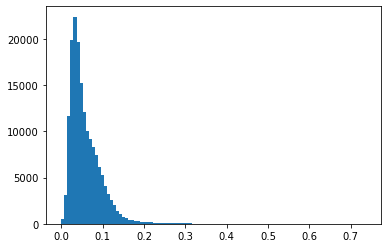

In [114]:
_ = plt.hist(adata.obs['pct_mito'], bins=100)

In [115]:
(adata.obs['pct_mito']>.1).value_counts()

False    148499
True      21129
Name: pct_mito, dtype: int64

In [116]:
pd.crosstab(adata.obs['Organ'], (adata.obs['pct_mito']>.1))

pct_mito,False,True
Organ,,
BLD,13397,1917
BMA,14726,4252
CAE,110,71
DUO,267,183
ILE,492,127
JEJEPI,19222,3999
JEJLP,14005,1435
LIV,3522,1654
LLN,39458,2172


In [117]:
adata = adata[:, ~dotgenes]

In [118]:
adata.obs['Organ'].value_counts()

LLN       41630
SPL       27592
JEJEPI    23221
BMA       18978
JEJLP     15440
BLD       15314
MLN       14934
LIV        5176
LNG        4936
ILE         619
DUO         450
SKM         396
OME         320
THY         255
CAE         181
TCL         120
SCL          66
Name: Organ, dtype: int64

In [119]:
countfn = os.path.join('../../Data/XTissueImmuneAtlas/T.counts.h5ad')


In [121]:
sc.write(countfn, adata)

# Process all organs together

169628 ../../Data/XTissueImmuneAtlas/T.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


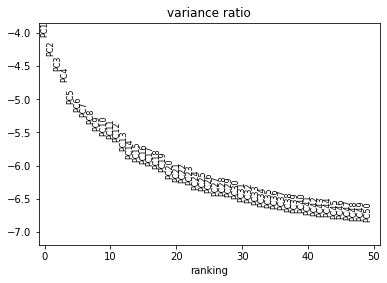

2022-05-24 19:57:48,614 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 19:59:31,518 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 20:01:14,562 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 20:02:57,641 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 20:04:40,758 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 20:06:02,350 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 20:07:11,134 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 20:08:11,242 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 20:09:06,947 - harmonypy - INFO - Converged after 8 iterations


169628 ../../Data/XTissueImmuneAtlas/T.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


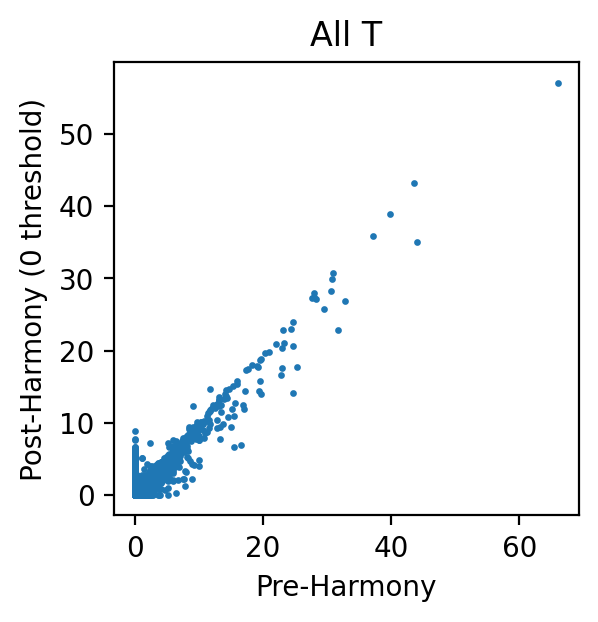

In [124]:
    countfn = os.path.join('../../Data/XTissueImmuneAtlas/T.counts.filt.h5ad')
    tpmfn = os.path.join('../../Data/XTissueImmuneAtlas/T.tp10k.filt.h5ad')
    correctedfn = os.path.join('../../Data/XTissueImmuneAtlas/T.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    hvgfn = countfn.replace('.h5ad', '.hvgs.txt')
    
    adata_org = adata.copy()
    sc.pp.filter_cells(adata_org, min_counts=500)
    sc.pp.filter_genes(adata_org, min_cells=10)
    sc.pp.highly_variable_genes(adata_org, n_top_genes=2000, flavor='seurat_v3')
    print(adata_org.shape[0], countfn)
    sc.write(countfn, adata_org)
    open(hvgfn, 'w').write('\n'.join(adata_org.var.index[adata_org.var['highly_variable']]))
    for_raw = adata_org.copy()
    sc.pp.normalize_per_cell(adata_org, counts_per_cell_after=1e4)
    sc.write(tpmfn, adata_org)
    adata_org.raw = for_raw
    del(for_raw)
    
    adata_org = adata_org[:, adata_org.var['highly_variable']]
    sc.pp.scale(adata_org, zero_center=False)
    sc.tl.pca(adata_org)
    sc.pl.pca_variance_ratio(adata_org, n_pcs=50, log=True)
    
    harmonizers = ['Organ', 'Donor', 'Chemistry']

    harmony_res = harmonypy.run_harmony(adata_org.obsm['X_pca'], adata_org.obs, harmonizers, max_iter_harmony = 20)
    Z = sc.AnnData(adata_org.raw.X, obs=adata_org.obs, var=adata_org.raw.var)
    Z = Z[:,adata_org.var.index]
    sc.pp.scale(Z, zero_center=False)
    X = np.array(Z.X.copy().todense())
    del(Z)
    
    _, X_corr, _, _ = moe_correct_ridge(X.T, None, None, harmony_res.R, None, harmony_res.K, None, harmony_res.Phi_moe, harmony_res.lamb)
    X_corr = X_corr.T
        
    adata_org_corrected = adata_org.copy()
    adata_org_corrected.X = X_corr
    adata_org_corrected.X[adata_org_corrected.X<0] = 0

    a = X.reshape(-1)
    b = X_corr.reshape(-1)
    if len(a) > 100000:
        ind = np.random.choice(a.shape[0], size=100000)
        a = a[ind]
        b = b[ind]

    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    ax.scatter(a, b, s=2)
    ax.set_xlabel('Pre-Harmony')
    ax.set_ylabel('Post-Harmony (0 threshold)')
    ax.set_title('All T')
    del(a)
    del(b)

    adata_org_corrected.raw = None
    print(adata_org.shape[0], correctedfn)
    sc.write(correctedfn, adata_org_corrected)

# Run cNMF combined

In [125]:
cnmfdir = '../../Data/XTissueImmuneAtlas'
name = 'AllTissues_NNDSVD_FilteredT'

cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
cnmf_count_fn = '../../Data/XTissueImmuneAtlas/T.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad'
cnmf_tpm_fn = '../../Data/XTissueImmuneAtlas/T.tp10k.filt.h5ad'
hvg_fn = '../../Data/XTissueImmuneAtlas/T.counts.filt.hvgs.txt'

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

In [126]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(10, 50), n_iter=10, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='nndsvd')


Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [127]:
total_workers = len(np.arange(10, 50))*10

In [128]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J AllTissues_NNDSVD_FilteredT -o ../../Data/XTissueImmuneAtlas/AllTissues_NNDSVD_FilteredT/log/AllTissues_NNDSVD_FilteredT.0.out.txt -e ../../Data/XTissueImmuneAtlas/AllTissues_NNDSVD_FilteredT/log/AllTissues_NNDSVD_FilteredT.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name AllTissues_NNDSVD_FilteredT --output-dir ../../Data/XTissueImmuneAtlas --total-workers 400 --worker-index 0"
Job <473086> is submitted to queue <short>.
bsub -q short -J AllTissues_NNDSVD_FilteredT -o ../../Data/XTissueImmuneAtlas/AllTissues_NNDSVD_FilteredT/log/AllTissues_NNDSVD_FilteredT.1.out.txt -e ../../Data/XTissueImmuneAtlas/AllTissues_NNDSVD_FilteredT/log/AllTissues_NNDSVD_FilteredT.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=

In [135]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
473437  dk718   RUN   short      cn071       cn009       *FilteredT May 24 20:24
473441  dk718   RUN   short      cn071       cmu240      *FilteredT May 24 20:24
473433  dk718   RUN   short      cn071       cmu228      *FilteredT May 24 20:24
473445  dk718   RUN   short      cn071       cmu231      *FilteredT May 24 20:24
473478  dk718   RUN   short      cn071       cmu238      *FilteredT May 24 20:24
473481  dk718   RUN   short      cn071       cmu186      *FilteredT May 24 20:24


In [140]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p =  run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)

In [136]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizat

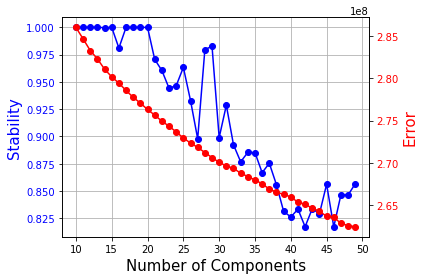

In [138]:
cnmf_obj.k_selection_plot()

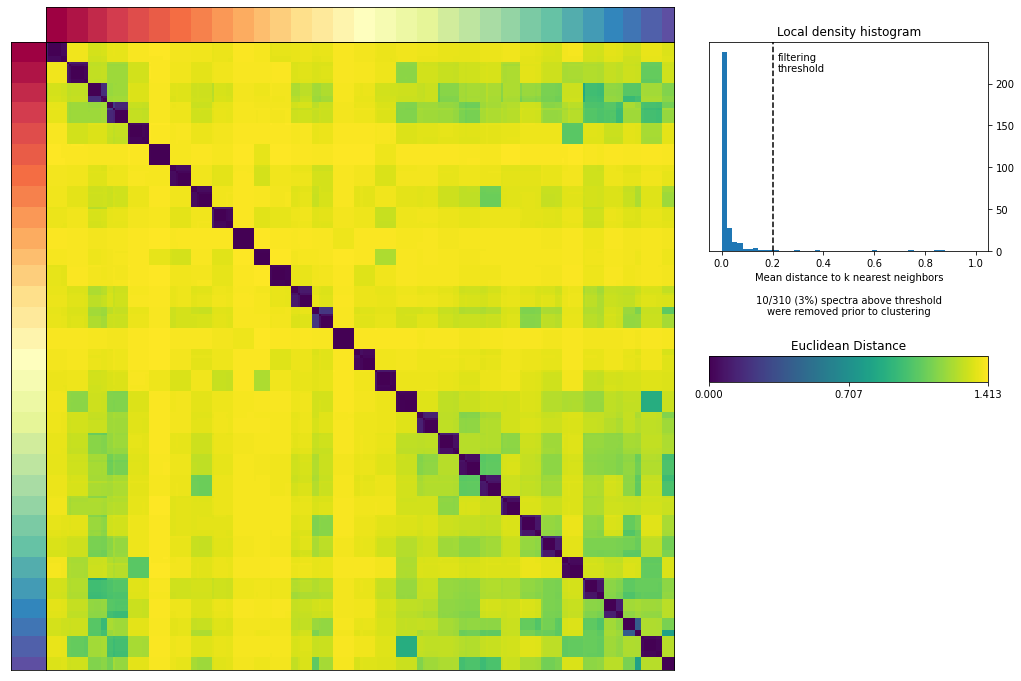

In [141]:
cnmf_obj.consensus(k=31, density_threshold=0.2)


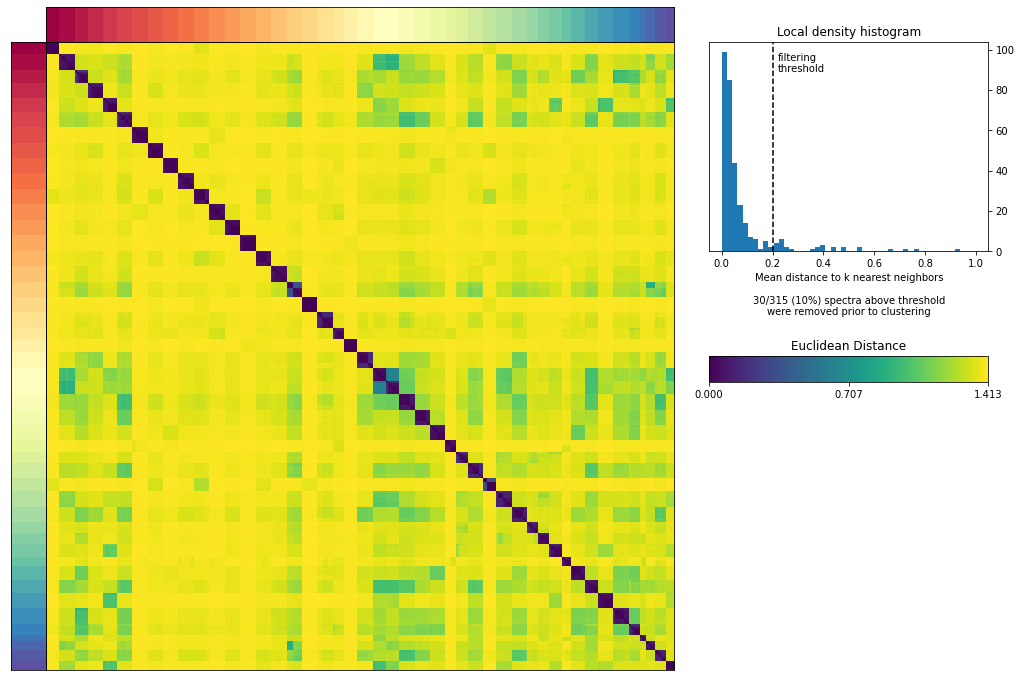

In [147]:
cnmf_obj.consensus(k=45, density_threshold=0.2)


In [142]:
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(name, cnmfdir, 31, 0.2)

In [143]:
topgenes.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,RPS12,RPS23,RPL13,RPL32,RPS13,RPS14,RPS8,RPS3A,RPS5,RPL19,RPL18A,RPS6,RPL29,RPL18,RPL30,RPL10,RPL34,RPL11,EEF1A1,RPL12
GEP1,EZR,FTH1,YPEL5,JUND,LMNA,CREM,METRNL,VIM,MYADM,RGCC,CRIP1,TNFAIP3,TAGLN2,FOSL2,SYAP1,ADGRE5,SELENOK,TGFB1,HSPA5,NR4A3
GEP2,CRYBG1,IL6ST,RNF19A,TXNIP,ARID5B,CH25H,SOCS3,TP53INP1,MAF,FYB1,NEAT1,ICOS,FKBP5,LINC-PINT,SESN3,CEMIP2,CMTM8,AP3M2,CCR4,ANKRD12
GEP3,CD8A,CD8B,CCL5,KLRK1,CCL4L2,CCL4,XCL1,XCL2,CD160,TNIP3,KLRD1,ITGA1,CCL3L1,PTPN22,ITM2C,CKLF,SPRY1,LINC01871,GPR34,CD244
GEP4,ACTB,ACTG1,PFN1,CFL1,CORO1A,TMSB4X,ARPC1B,GAPDH,COTL1,MYL6,RAC2,ARHGDIB,SH3BGRL3,ARPC2,CLIC1,PPP1CA,TMSB10,PSME2,CNN2,MYL12A
GEP5,FOS,IER2,JUNB,JUN,DUSP1,BTG2,ZFP36,EGR1,CD69,NFKBIA,FOSB,DUSP2,PPP1R15A,CSRNP1,GADD45B,NFKBIZ,TNF,IER3,KLF6,DDIT4
GEP6,HSPA1A,HSP90AA1,DNAJB1,HSPH1,HSPE1,HSPD1,HSP90AB1,HSPA1B,HSPA8,CACYBP,HSPB1,DNAJA1,UBC,BAG3,HSPA6,DOK2,UBB,DNAJA4,ZFAND2A,FKBP4
GEP7,FGFBP2,GZMH,NKG7,GZMB,PRF1,FCGR3A,ADGRG1,PRSS23,GNLY,CTSW,CX3CR1,PLEK,C1orf21,C12orf75,ITGB1,SAMD3,CST7,S1PR5,HLA-C,S100A4
GEP8,IL4I1,CEBPD,SLC4A10,IL23R,KLRB1,RORC,CCR6,CA2,NCR3,CCL20,LTK,LTB,TNFSF13B,TRAV1-2,CXCR6,IL18RAP,TLE1,RORA,IL7R,ERN1
GEP9,MT-CYB,MT-CO1,MT-CO2,MT-CO3,MT-ND1,MT-ND3,MT-ND2,MT-ATP6,MT-ND5,MT-ND4,MT-ND4L,MT-ND6,MT-ATP8,MTRNR2L12,MALAT1,NEAT1,ATM,NKTR,POLR2J3,AAK1


In [148]:
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(name, cnmfdir, 45, 0.2)

In [149]:
topgenes.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,RPS23,RPS3A,RPL13,RPS13,RPS12,RPS14,RPS5,RPL32,RPS8,RPS6,RPL19,RPL18A,RPL29,RPL18,RPL30,RPL34,RPL11,RPL10,RPL12,EEF1A1
GEP1,EZR,YPEL5,FTH1,JUND,CREM,METRNL,MYADM,CRIP1,SYAP1,VIM,TNFAIP3,LDLRAD4,FOSL2,ZNF331,LMNA,RGCC,SELENOK,ATP1B3,REL,IDS
GEP2,CRYBG1,SOCS3,CH25H,IL6ST,TXNIP,ARID5B,DDIT4,RNF19A,ICOS,TP53INP1,SOCS1,CMTM8,ZFP36L2,EPGN,FKBP5,CCR4,FYB1,AREG,BATF,AP3M2
GEP3,CD8B,CD8A,CAPG,CD160,ITM2C,XCL1,CKLF,CD244,ITGAE,ABI3,CCL5,CD248,KLRC1,KLRK1,TMSB4X,TMIGD2,CD3D,CD7,XCL2,ITGA1
GEP4,ACTG1,ACTB,PFN1,CFL1,CORO1A,ARPC1B,MYL6,COTL1,TMSB4X,GAPDH,ARPC2,ARHGDIB,CNN2,ARPC5,PPP1CA,TMSB10,CLIC1,RAC2,ACTR3,ARPC3
GEP5,LTB,S100A11,S100A4,TIMP1,S100A10,EMP3,S100A6,CD52,LMNA,AHNAK,TMSB10,VIM,ITGB1,NEFL,PLP2,RPL41,IL32,SH3BGRL3,CD82,NPDC1
GEP6,GZMK,CMC1,EOMES,DTHD1,CST7,SH2D1A,KLRG1,LYST,DUSP2,CCL5,SAMD3,CCL3,PLEK,CCL4,LYAR,HCST,HLA-DPA1,CTSW,HLA-DPB1,CD74
GEP7,IER2,FOS,JUN,JUNB,EGR1,DUSP1,BTG2,ZFP36,FOSB,CD69,NFKBIA,PPP1R15A,DUSP2,CSRNP1,NFKBIZ,GADD45B,IER3,KLF6,TNF,PHLDA1
GEP8,HSPA1A,HSP90AA1,HSPD1,HSPH1,HSPE1,DNAJB1,HSP90AB1,HSPB1,CACYBP,HSPA8,UBC,HSPA1B,DNAJA1,DOK2,BAG3,HSPA6,DNAJA4,UBB,ZFAND2A,FKBP4
GEP9,FGFBP2,GZMH,NKG7,GZMB,PRF1,FCGR3A,ADGRG1,PRSS23,GNLY,CX3CR1,CTSW,C1orf21,C12orf75,ITGB1,PLEK,S100A4,S1PR5,CD52,EFHD2,TTC38


In [150]:
spectra[0].sort_values(ascending=False).head(50)


RPS23     0.005262
RPS3A     0.005228
RPL13     0.005194
RPS13     0.005157
RPS12     0.005147
RPS14     0.005109
RPS5      0.005086
RPL32     0.005047
RPS8      0.005016
RPS6      0.004996
RPL19     0.004949
RPL18A    0.004822
RPL29     0.004788
RPL18     0.004785
RPL30     0.004748
RPL34     0.004641
RPL11     0.004640
RPL10     0.004570
RPL12     0.004569
EEF1A1    0.004461
RPL5      0.004460
EEF1B2    0.004445
RPS25     0.004439
RPL22     0.004421
RPS15A    0.004419
RPS18     0.004409
RPL35A    0.004402
RPL10A    0.004358
NACA      0.004345
RPL9      0.004342
RPS27A    0.004338
RPS2      0.004321
RPL3      0.004314
RPL14     0.004303
RPS15     0.004294
EEF1G     0.004286
RPS9      0.004284
RACK1     0.004229
RPL7A     0.004186
RPL7      0.004167
RPL37     0.004135
RPS3      0.004131
RPS28     0.004130
RPSA      0.004127
RPS4X     0.004122
RPL21     0.004107
RPL26     0.004079
RPLP2     0.004045
RPS21     0.003962
RPL28     0.003861
Name: 0, dtype: float64

In [146]:
spectra[0].sort_values(ascending=False).head(100).tail(50)

RPL21         0.003891
RPL41         0.003869
RPL7          0.003802
RPL8          0.003791
RPS16         0.003724
RPLP0         0.003687
FAU           0.003655
RPL36         0.003613
RPL4          0.003587
TPT1          0.003561
RPL24         0.003540
RPS7          0.003504
RPL23A        0.003495
RPL17         0.003491
RPL15         0.003409
CCR7          0.003398
RPL6          0.003381
SELL          0.003369
GAS5          0.003345
LDHB          0.003342
SNHG29        0.003325
RPL36A        0.003313
RPL31         0.003300
RPS27         0.003271
RPL37A        0.003258
RPL27         0.003207
LEF1          0.003083
UBA52         0.003078
RPS24         0.003062
RPLP1         0.002996
EIF3E         0.002988
NOP53         0.002978
RPS19         0.002975
TCF7          0.002934
RPL38         0.002882
EEF1D         0.002839
MAL           0.002773
RPL23         0.002730
BTF3          0.002708
EEF2          0.002702
NPM1          0.002667
FHIT          0.002660
RPL13A        0.002632
COX4I1     

In [154]:
spectra.loc['SELL', :].sort_values(ascending=False)

0     0.003322
25    0.002697
12    0.002192
24    0.002057
31    0.000699
5     0.000646
27    0.000499
20    0.000497
19    0.000316
30    0.000227
41    0.000224
42    0.000201
35    0.000198
34    0.000067
2     0.000051
43   -0.000002
17   -0.000004
44   -0.000024
23   -0.000068
13   -0.000092
26   -0.000156
33   -0.000179
32   -0.000383
37   -0.000403
16   -0.000417
15   -0.000452
9    -0.000521
8    -0.000610
40   -0.000611
36   -0.000611
28   -0.000784
18   -0.000837
4    -0.000879
39   -0.000925
21   -0.001007
7    -0.001053
3    -0.001131
6    -0.001228
11   -0.001243
22   -0.001252
1    -0.001470
38   -0.001637
10   -0.001874
29   -0.001876
14   -0.002094
Name: SELL, dtype: float64

# Split per organ

Trying to set attribute `.obs` of view, copying.


ILE 619 ../../Data/XTissueImmuneAtlas/PerTissue/T.ILE.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


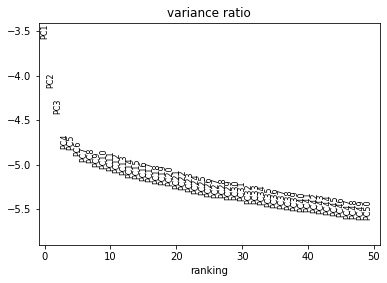

2022-05-24 22:15:20,207 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:15:20,299 - harmonypy - INFO - Iteration 2 of 20


['Donor']


2022-05-24 22:15:20,387 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:15:20,428 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:15:20,464 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:15:20,492 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:15:20,520 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:15:20,548 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 22:15:20,576 - harmonypy - INFO - Converged after 8 iterations


ILE 619 ../../Data/XTissueImmuneAtlas/PerTissue/ILE.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


LNG 4936 ../../Data/XTissueImmuneAtlas/PerTissue/T.LNG.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


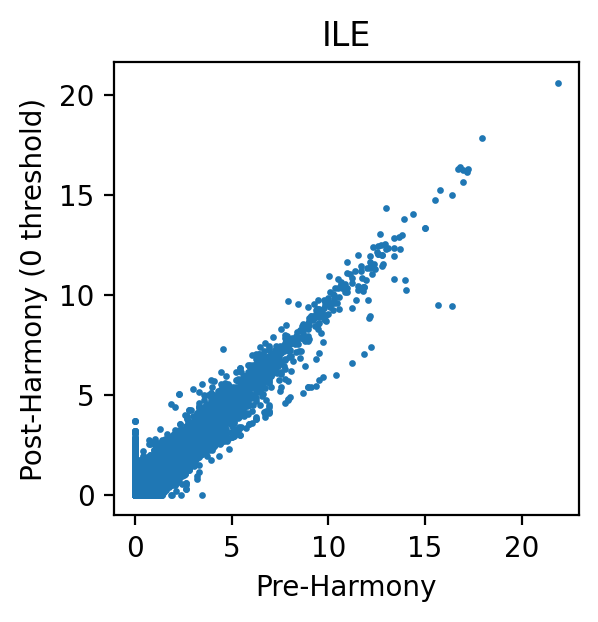

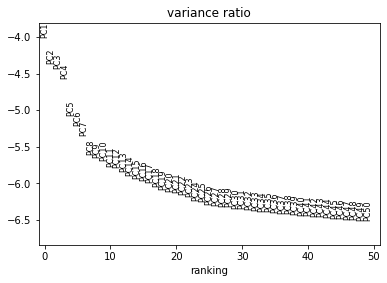

['Donor', 'Chemistry']


2022-05-24 22:15:26,984 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:15:28,607 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:15:30,224 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:15:31,854 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:15:33,465 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:15:34,599 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:15:36,229 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:15:37,308 - harmonypy - INFO - Converged after 7 iterations


LNG 4936 ../../Data/XTissueImmuneAtlas/PerTissue/LNG.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


LLN 41630 ../../Data/XTissueImmuneAtlas/PerTissue/T.LLN.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


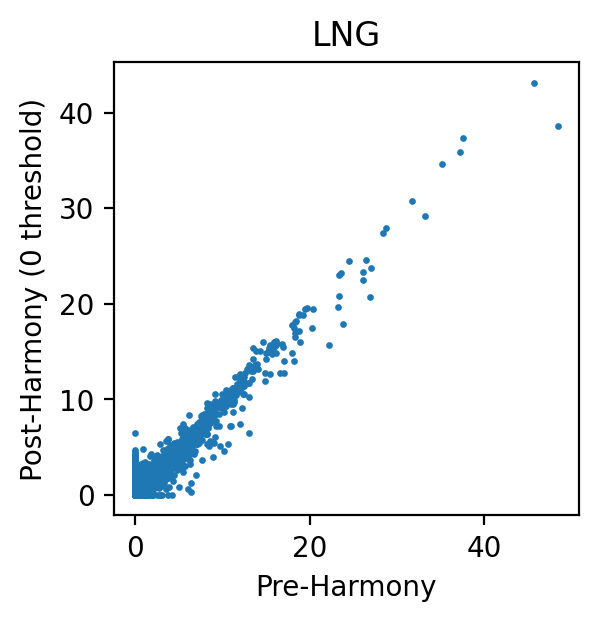

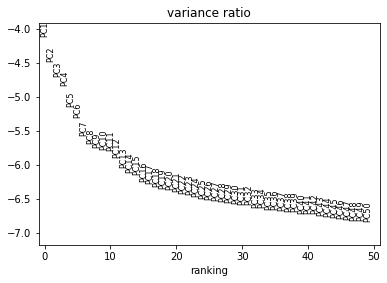

['Donor', 'Chemistry']


2022-05-24 22:16:38,689 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:16:53,638 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:17:08,567 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:17:23,366 - harmonypy - INFO - Converged after 3 iterations


LLN 41630 ../../Data/XTissueImmuneAtlas/PerTissue/LLN.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


MLN 14934 ../../Data/XTissueImmuneAtlas/PerTissue/T.MLN.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


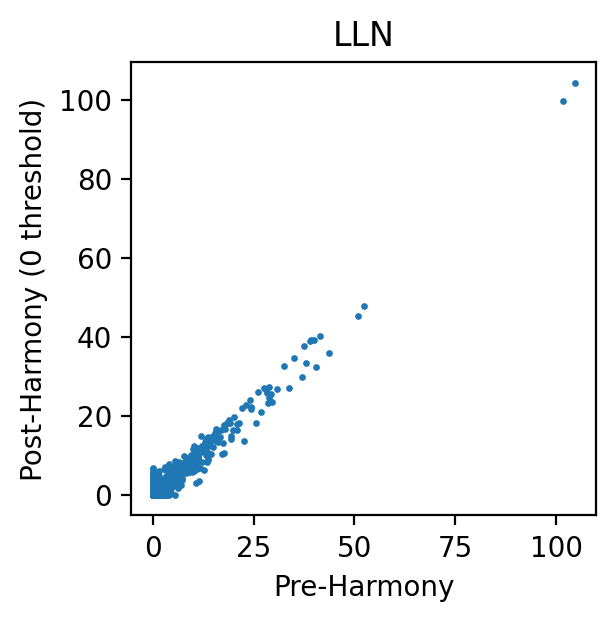

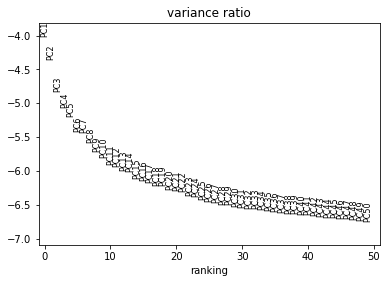

['Donor', 'Chemistry']


2022-05-24 22:19:05,403 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:19:10,356 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:19:15,173 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:19:19,784 - harmonypy - INFO - Converged after 3 iterations


MLN 14934 ../../Data/XTissueImmuneAtlas/PerTissue/MLN.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


BMA 18978 ../../Data/XTissueImmuneAtlas/PerTissue/T.BMA.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


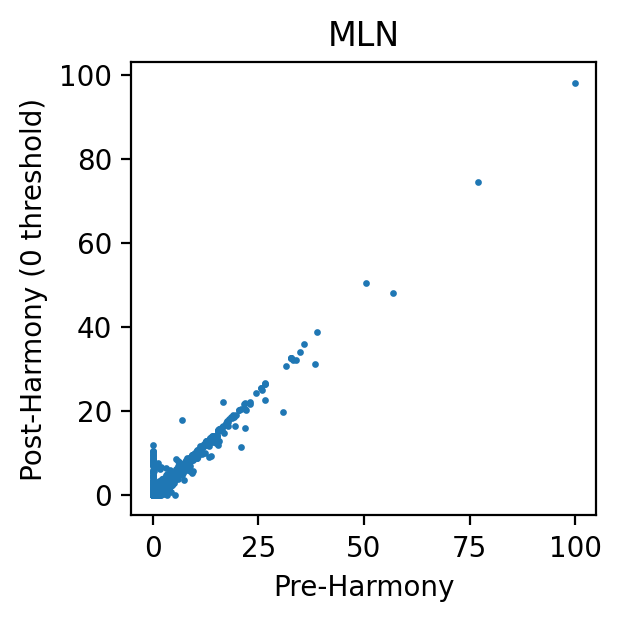

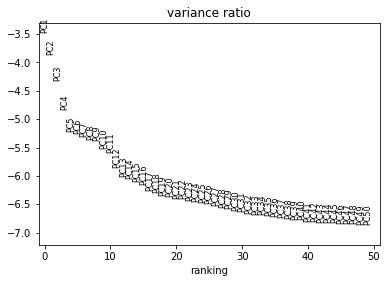

['Donor', 'Chemistry']


2022-05-24 22:20:15,496 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:20:21,427 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:20:27,364 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:20:33,343 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:20:37,153 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:20:41,494 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:20:43,743 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:20:48,068 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 22:20:50,049 - harmonypy - INFO - Converged after 8 iterations


BMA 18978 ../../Data/XTissueImmuneAtlas/PerTissue/BMA.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


SKM 396 ../../Data/XTissueImmuneAtlas/PerTissue/T.SKM.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


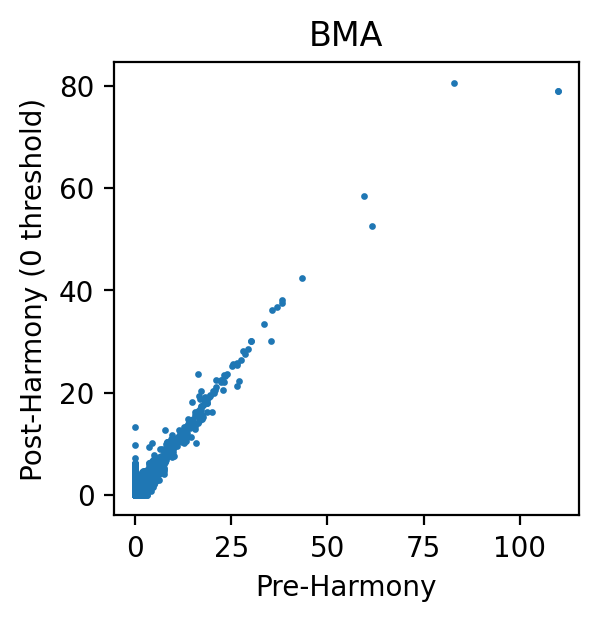

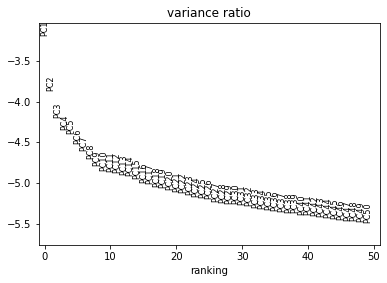

2022-05-24 22:21:28,702 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:21:28,757 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:21:28,798 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:21:28,822 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:21:28,842 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:21:28,860 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:21:28,880 - harmonypy - INFO - Converged after 6 iterations


['Donor']
SKM 396 ../../Data/XTissueImmuneAtlas/PerTissue/SKM.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


LIV 5176 ../../Data/XTissueImmuneAtlas/PerTissue/T.LIV.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


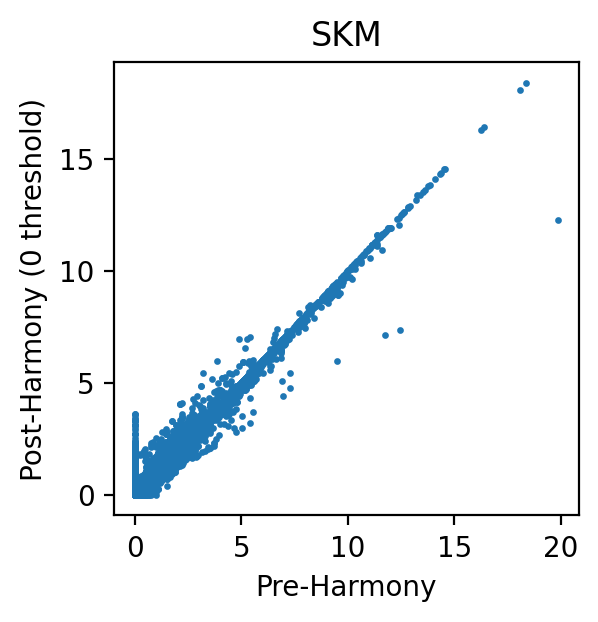

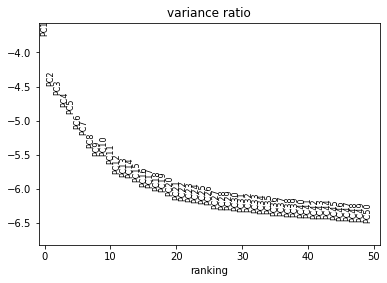

['Donor', 'Chemistry']


2022-05-24 22:21:35,629 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:21:37,176 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:21:38,720 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:21:40,269 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:21:41,813 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:21:43,165 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:21:44,229 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:21:45,297 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 22:21:46,224 - harmonypy - INFO - Iteration 9 of 20
2022-05-24 22:21:47,153 - harmonypy - INFO - Iteration 10 of 20
2022-05-24 22:21:47,943 - harmonypy - INFO - Iteration 11 of 20
2022-05-24 22:21:48,597 - harmonypy - INFO - Converged after 11 iterations


LIV 5176 ../../Data/XTissueImmuneAtlas/PerTissue/LIV.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


SPL 27592 ../../Data/XTissueImmuneAtlas/PerTissue/T.SPL.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


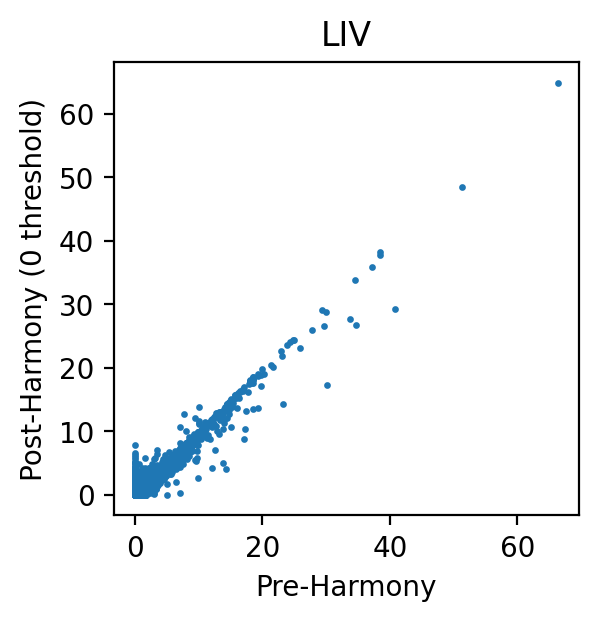

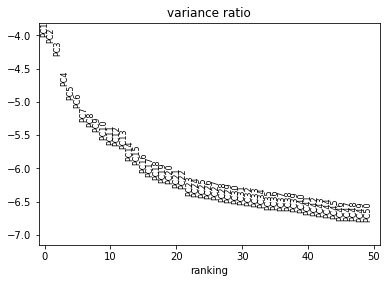

['Donor', 'Chemistry']


2022-05-24 22:22:28,526 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:22:38,021 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:22:47,433 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:22:56,944 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:23:06,326 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:23:15,558 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:23:19,889 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:23:24,229 - harmonypy - INFO - Converged after 7 iterations


SPL 27592 ../../Data/XTissueImmuneAtlas/PerTissue/SPL.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


OME 320 ../../Data/XTissueImmuneAtlas/PerTissue/T.OME.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


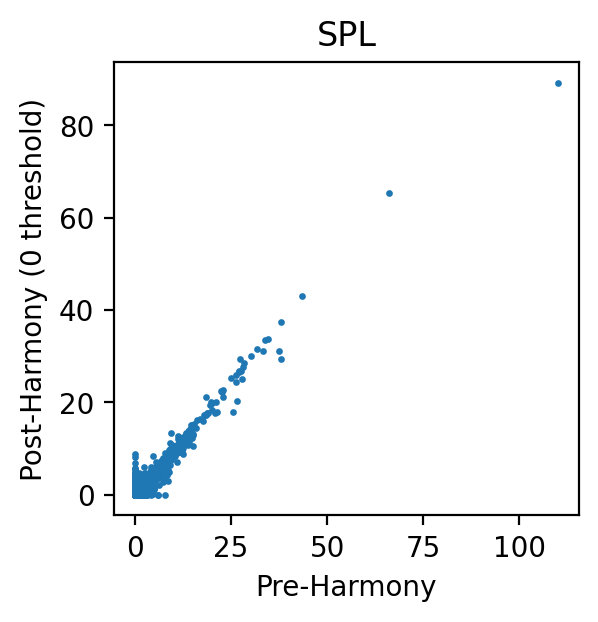

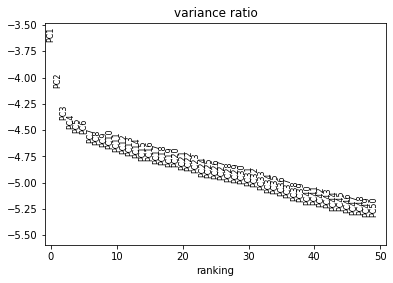

2022-05-24 22:24:20,038 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:24:20,088 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:24:20,117 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:24:20,138 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:24:20,154 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:24:20,169 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:24:20,185 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:24:20,201 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 22:24:20,217 - harmonypy - INFO - Converged after 8 iterations


['Donor']
OME 320 ../../Data/XTissueImmuneAtlas/PerTissue/OME.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


CAE 181 ../../Data/XTissueImmuneAtlas/PerTissue/T.CAE.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


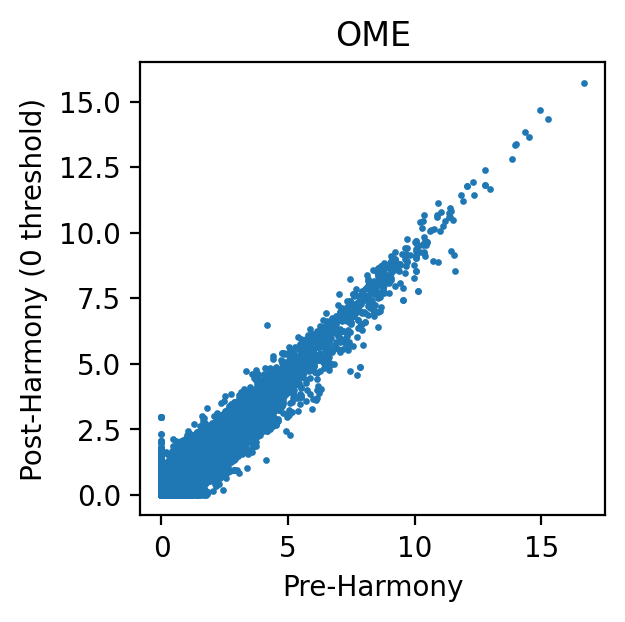

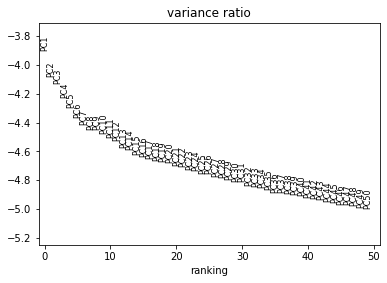

2022-05-24 22:24:21,320 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:24:21,360 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:24:21,379 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:24:21,396 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:24:21,415 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:24:21,430 - harmonypy - INFO - Converged after 5 iterations


['Donor']
CAE 181 ../../Data/XTissueImmuneAtlas/PerTissue/CAE.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


THY 255 ../../Data/XTissueImmuneAtlas/PerTissue/T.THY.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


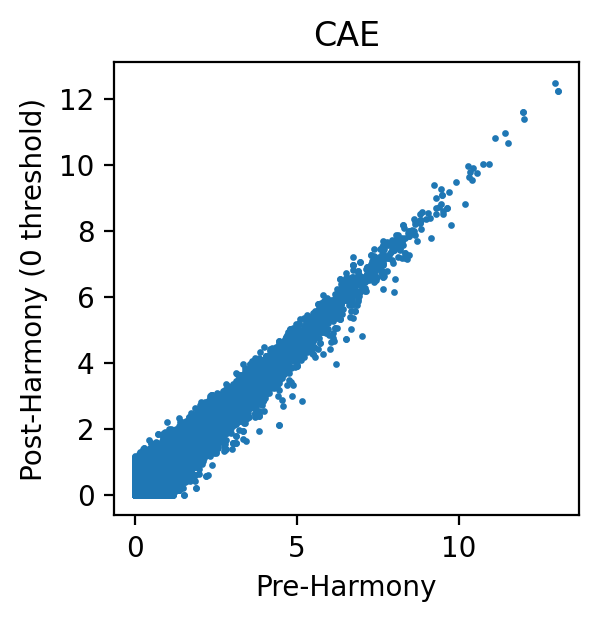

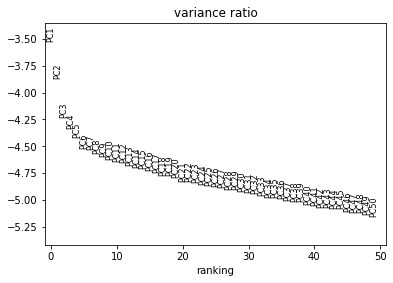

[]
THY 255 ../../Data/XTissueImmuneAtlas/PerTissue/THY.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


DUO 450 ../../Data/XTissueImmuneAtlas/PerTissue/T.DUO.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


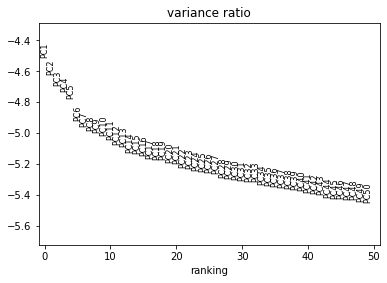

2022-05-24 22:24:23,756 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:24:23,826 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:24:23,893 - harmonypy - INFO - Iteration 3 of 20


['Donor']


2022-05-24 22:24:23,940 - harmonypy - INFO - Iteration 4 of 20
2022-05-24 22:24:23,967 - harmonypy - INFO - Iteration 5 of 20
2022-05-24 22:24:23,990 - harmonypy - INFO - Iteration 6 of 20
2022-05-24 22:24:24,011 - harmonypy - INFO - Iteration 7 of 20
2022-05-24 22:24:24,038 - harmonypy - INFO - Iteration 8 of 20
2022-05-24 22:24:24,062 - harmonypy - INFO - Iteration 9 of 20
2022-05-24 22:24:24,085 - harmonypy - INFO - Iteration 10 of 20
2022-05-24 22:24:24,106 - harmonypy - INFO - Iteration 11 of 20
2022-05-24 22:24:24,127 - harmonypy - INFO - Iteration 12 of 20
2022-05-24 22:24:24,147 - harmonypy - INFO - Iteration 13 of 20
2022-05-24 22:24:24,168 - harmonypy - INFO - Iteration 14 of 20
2022-05-24 22:24:24,188 - harmonypy - INFO - Converged after 14 iterations


DUO 450 ../../Data/XTissueImmuneAtlas/PerTissue/DUO.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


BLD 15314 ../../Data/XTissueImmuneAtlas/PerTissue/T.BLD.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


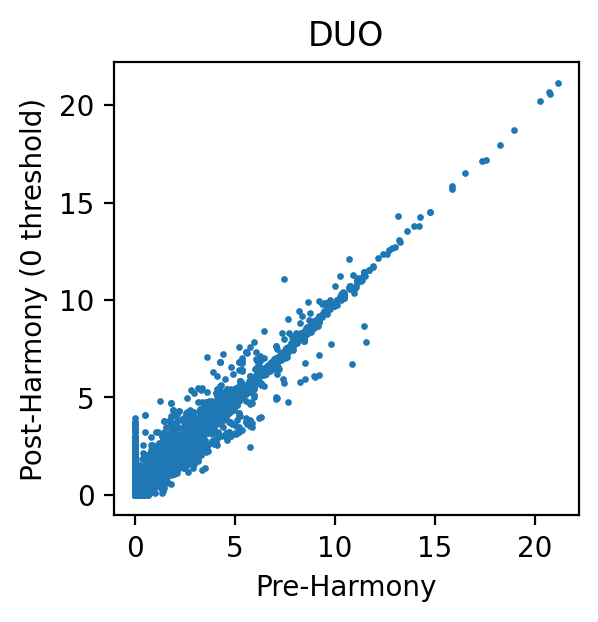

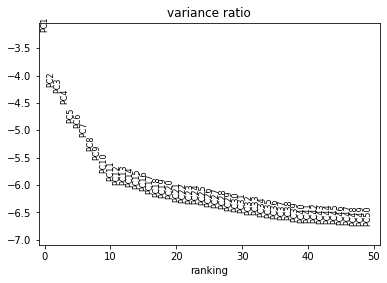

['Donor', 'Chemistry']


2022-05-24 22:24:43,482 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:24:48,256 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:24:53,030 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:24:57,810 - harmonypy - INFO - Converged after 3 iterations


BLD 15314 ../../Data/XTissueImmuneAtlas/PerTissue/BLD.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


TCL 120 ../../Data/XTissueImmuneAtlas/PerTissue/T.TCL.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


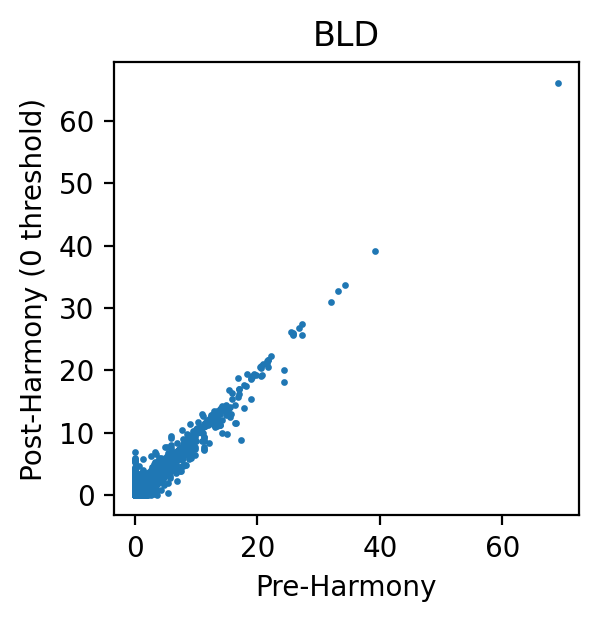

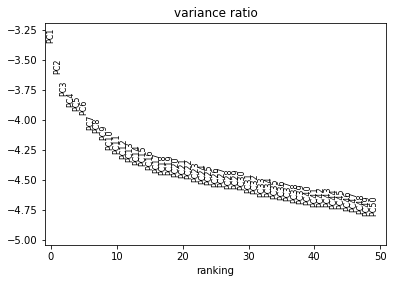

[]
TCL 120 ../../Data/XTissueImmuneAtlas/PerTissue/TCL.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


SCL 66 ../../Data/XTissueImmuneAtlas/PerTissue/T.SCL.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


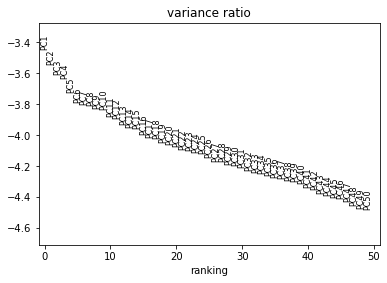

[]
SCL 66 ../../Data/XTissueImmuneAtlas/PerTissue/SCL.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


JEJLP 15440 ../../Data/XTissueImmuneAtlas/PerTissue/T.JEJLP.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


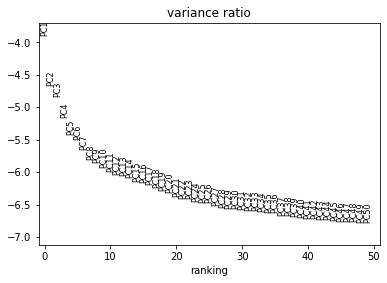

['Donor', 'Chemistry']


2022-05-24 22:25:55,670 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:26:00,302 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:26:04,935 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:26:09,555 - harmonypy - INFO - Converged after 3 iterations


JEJLP 15440 ../../Data/XTissueImmuneAtlas/PerTissue/JEJLP.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


Trying to set attribute `.obs` of view, copying.


JEJEPI 23221 ../../Data/XTissueImmuneAtlas/PerTissue/T.JEJEPI.counts.filt.h5ad
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


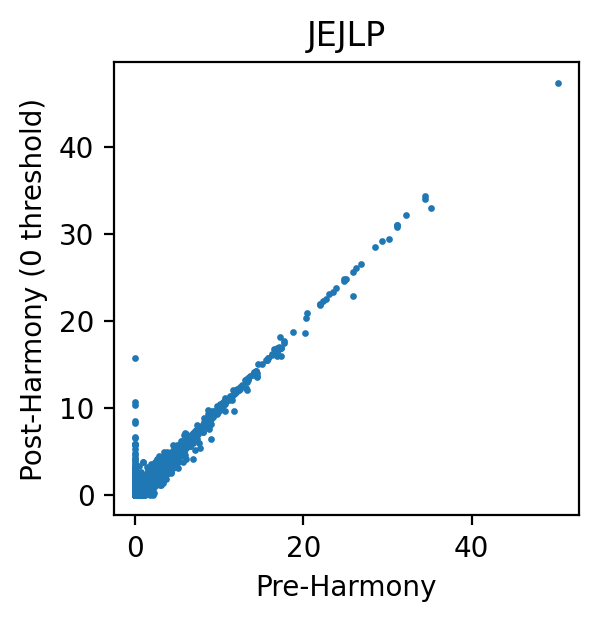

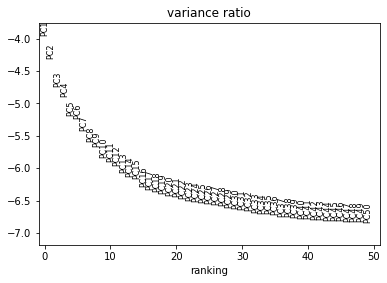

['Donor', 'Chemistry']


2022-05-24 22:27:09,517 - harmonypy - INFO - Iteration 1 of 20
2022-05-24 22:27:16,672 - harmonypy - INFO - Iteration 2 of 20
2022-05-24 22:27:23,849 - harmonypy - INFO - Iteration 3 of 20
2022-05-24 22:27:31,038 - harmonypy - INFO - Converged after 3 iterations


JEJEPI 23221 ../../Data/XTissueImmuneAtlas/PerTissue/JEJEPI.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


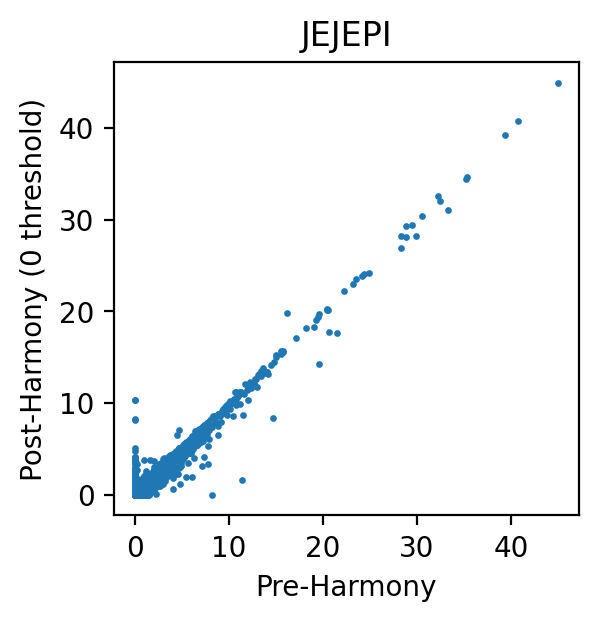

In [155]:
for organ in adata.obs['Organ'].unique():
    countfn = os.path.join('../../Data/XTissueImmuneAtlas/PerTissue', 'T.%s.counts.filt.h5ad' % organ)
    tpmfn = os.path.join('../../Data/XTissueImmuneAtlas/PerTissue', 'T.%s.tp10k.filt.h5ad' % organ)
    correctedfn = os.path.join('../../Data/XTissueImmuneAtlas/PerTissue', '%s.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % organ)
    hvgfn = countfn.replace('.h5ad', '.hvgs.txt')
    
    
    adata_org = adata[adata.obs['Organ']==organ, :]
    sc.pp.filter_cells(adata_org, min_counts=500)
    sc.pp.filter_genes(adata_org, min_cells=10)
    sc.pp.highly_variable_genes(adata_org, n_top_genes=2000, flavor='seurat_v3')
    print(organ, adata_org.shape[0], countfn)
    sc.write(countfn, adata_org)
    open(hvgfn, 'w').write('\n'.join(adata_org.var.index[adata_org.var['highly_variable']]))
    for_raw = adata_org.copy()
    sc.pp.normalize_per_cell(adata_org, counts_per_cell_after=1e4)
    sc.write(tpmfn, adata_org)
    adata_org.raw = for_raw
    del(for_raw)
    
    adata_org = adata_org[:, adata_org.var['highly_variable']]
    sc.pp.scale(adata_org, zero_center=False)
    sc.tl.pca(adata_org)
    sc.pl.pca_variance_ratio(adata_org, n_pcs=50, log=True)
    
    harmonizers = []
    if adata_org.obs['Donor'].unique().shape[0] > 1:
        harmonizers.append('Donor')
        
    if adata_org.obs['Chemistry'].unique().shape[0] > 1:
        harmonizers.append('Chemistry')
        
    print(harmonizers)
    if len(harmonizers) > 0:
        harmony_res = harmonypy.run_harmony(adata_org.obsm['X_pca'], adata_org.obs, harmonizers, max_iter_harmony = 20)
        Z = sc.AnnData(adata_org.raw.X, obs=adata_org.obs, var=adata_org.raw.var)
        Z = Z[:,adata_org.var.index]
        sc.pp.scale(Z, zero_center=False)
        X = np.array(Z.X.copy().todense())
        del(Z)
        
        _, X_corr, _, _ = moe_correct_ridge(X.T, None, None, harmony_res.R, None, harmony_res.K,
                                            None, harmony_res.Phi_moe, harmony_res.lamb)
        X_corr = X_corr.T
        
        adata_org_corrected = adata_org.copy()
        adata_org_corrected.X = X_corr
        adata_org_corrected.X[adata_org_corrected.X<0] = 0

        a = X.reshape(-1)
        b = X_corr.reshape(-1)
        if len(a) > 100000:
            ind = np.random.choice(a.shape[0], size=100000)
            a = a[ind]
            b = b[ind]

        (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
        ax.scatter(a, b, s=2)
        ax.set_xlabel('Pre-Harmony')
        ax.set_ylabel('Post-Harmony (0 threshold)')
        ax.set_title(organ)
        del(a)
        del(b)

    adata_org_corrected.raw = None
    print(organ, adata_org.shape[0], correctedfn)
    sc.write(correctedfn, adata_org_corrected)

# Run cNMF per organ

## NNDSVD initialization

In [156]:
cnmfdir = '../../Data/XTissueImmuneAtlas/PerTissue'


In [157]:
adata.obs['Organ'].value_counts().index

CategoricalIndex(['LLN', 'SPL', 'JEJEPI', 'BMA', 'JEJLP', 'BLD', 'MLN', 'LIV',
                  'LNG', 'ILE', 'DUO', 'SKM', 'OME', 'THY', 'CAE', 'TCL',
                  'SCL'],
                 categories=['BLD', 'BMA', 'CAE', 'DUO', 'ILE', 'JEJEPI', 'JEJLP', 'LIV', ...], ordered=False, dtype='category')

In [162]:
len(range(5,30))*5

125

In [165]:
orgs = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'BLD', 'JEJLP', 'MLN', 'LIV',
                  'LNG', 'ILE', 'SKM', 'DUO', 'OME', 'THY', 'CAE', 'TCL',
                  'SCL']

total_workers = 125
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'


for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    name = o + '_FixFilt_NNDSVD'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(5, 30), n_iter=5,
                     tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='nndsvd')
    
    jname = name
    cnmfout = os.path.join(cnmfdir, name, 'log')
    
    if not os.path.exists(cnmfout): os.mkdir(cnmfout)

    for i in range(total_workers):
        cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
        e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
        o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
        bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
        print(bsub_cmd)
        !{bsub_cmd}

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
bsub -q short -J LLN_FixFilt_NNDSVD -o ../../Data/XTissueImmuneAtlas/PerTissue/LLN_FixFilt_NNDSVD/log/LLN_FixFilt_NNDSVD.0.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/LLN_FixFilt_NNDSVD/log/LLN_FixFilt_NNDSVD.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name LLN_FixFilt_NNDSVD --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 125 --worker-index 0"
Job <480376> is submitted to queue <short>.
bsub -q short -J LLN_FixFilt_NNDSVD -o ../../Data/XTissueImmuneAtlas/PerTissue/LLN_FixFilt_NNDSVD/log/LLN_FixFilt_NNDSVD.1.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/LLN_FixFilt_NNDSVD/log/LLN_FixFilt_NNDSVD.1.err.txt -R "rusage[mem=2000]" -R "select[hnam

In [166]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
480447  dk718   RUN   short      cn071       cn008       *lt_NNDSVD May 25 15:59
480481  dk718   RUN   short      cn071       cn008       *lt_NNDSVD May 25 15:59
480483  dk718   RUN   short      cn071       cmu239      *lt_NNDSVD May 25 15:59
480486  dk718   RUN   short      cn071       cmu231      *lt_NNDSVD May 25 15:59
480493  dk718   RUN   short      cn071       cn043       *lt_NNDSVD May 25 15:59
480494  dk718   RUN   short      cn071       cn052       *lt_NNDSVD May 25 15:59
480497  dk718   RUN   short      cn071       cn049       *lt_NNDSVD May 25 15:59
480500  dk718   RUN   short      cn071       cn034       *lt_NNDSVD May 25 15:59
480499  dk718   RUN   short      cn071       cn036       *lt_NNDSVD May 25 15:59
480472  dk718   RUN   short      cn071       cmu178      *lt_NNDSVD May 25 15:59
480473  dk718   RUN   short      cn071       cmu180      *lt_NNDSVD May 25 15:59
480498  dk718   RUN   short  

In [ ]:
orgs = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'BLD', 'JEJLP', 'MLN', 'LIV',
                  'LNG', 'ILE', 'SKM', 'DUO', 'OME', 'THY', 'CAE', 'TCL',
                  'SCL']
#orgs_to_run = [ 'BLD', 'JEJLP', 'MLN', 'LIV', 'LNG']
orgs_to_run = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']



total_workers = 200
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for o in orgs_to_run:
    name = o + '_FixFilt_NNDSVD'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_count_fn = os.path.join(cnmfdir,  'T.%s.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % o)
    cnmf_tpm_fn = os.path.join(cnmfdir, 'T.%s.tp10k.filt.h5ad' % o)
    hvg_fn = os.path.join(cnmfdir,  'T.%s.counts.filt.hvgs.txt' % o)
    cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(5, 25), n_iter=10,
                tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn)
    name = o

    jname = name
    cnmfout = os.path.join(cnmfdir, name, 'log')
    

    if not os.path.exists(cnmfout): os.mkdir(cnmfout)

    for i in range(total_workers):
        cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
        e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
        o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
        bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
        print(bsub_cmd)
        !{bsub_cmd}

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


bsub -q short -J BLD -o ../../Data/XTissueImmuneAtlas/PerTissue/BLD/log/BLD.0.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/BLD/log/BLD.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name BLD --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 200 --worker-index 0"
Job <462632> is submitted to queue <short>.
bsub -q short -J BLD -o ../../Data/XTissueImmuneAtlas/PerTissue/BLD/log/BLD.1.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/BLD/log/BLD.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name BLD --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 200 --worker-index 1"
Job <46263

In [80]:
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    print(o)
    cnmf_obj = cNMF(output_dir=cnmfdir, name=o)
    cnmf_obj.combine()

LLN
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
SPL
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizatio

In [89]:
yaml.load(open(cnmf_obj.paths['nmf_run_parameters']), Loader=yaml.FullLoader)

{'alpha_H': 0.0,
 'alpha_W': 0.0,
 'beta_loss': 'frobenius',
 'init': 'nndsvd',
 'l1_ratio': 0.0,
 'max_iter': 1000,
 'solver': 'cd',
 'tol': 0.0001}

LLN
SPL
BMA
JEJEPI
ILE


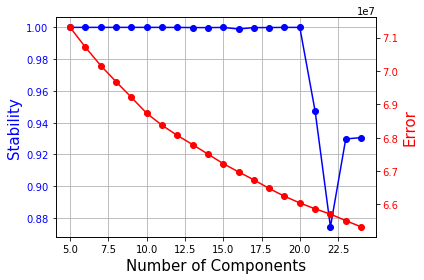

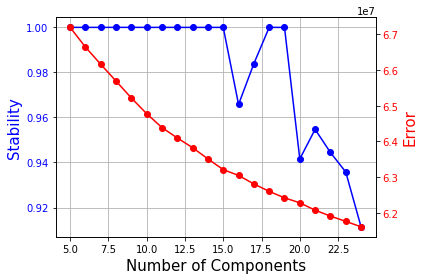

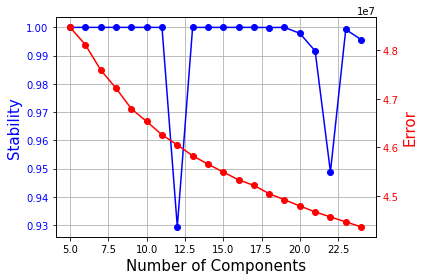

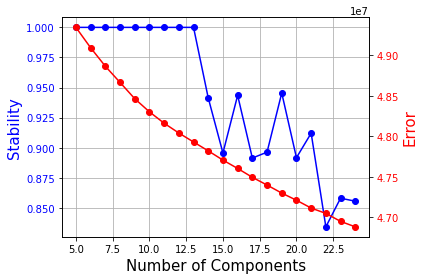

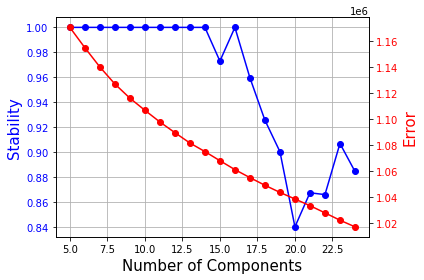

In [81]:
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    print(o)
    cnmf_obj = cNMF(output_dir=cnmfdir, name=o)
    cnmf_obj.k_selection_plot()

In [93]:
vc = adata.obs['Organ'].value_counts()
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    print(o, vc.loc[o])

LLN 45319
SPL 38727
BMA 29178
JEJEPI 26574
ILE 698


LLN
SPL
BMA
JEJEPI
ILE


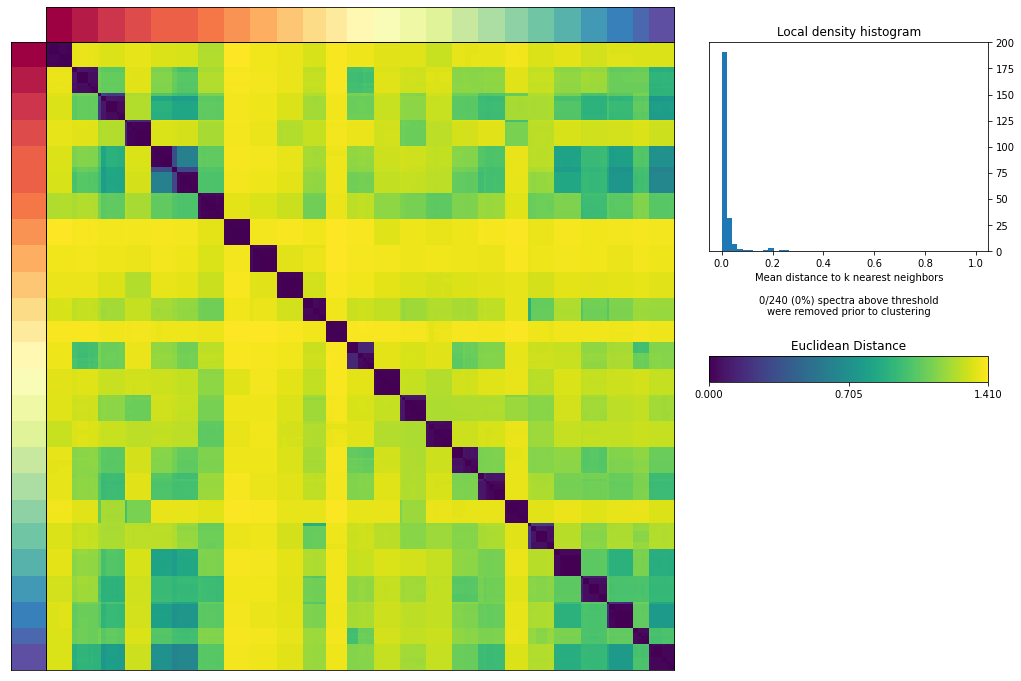

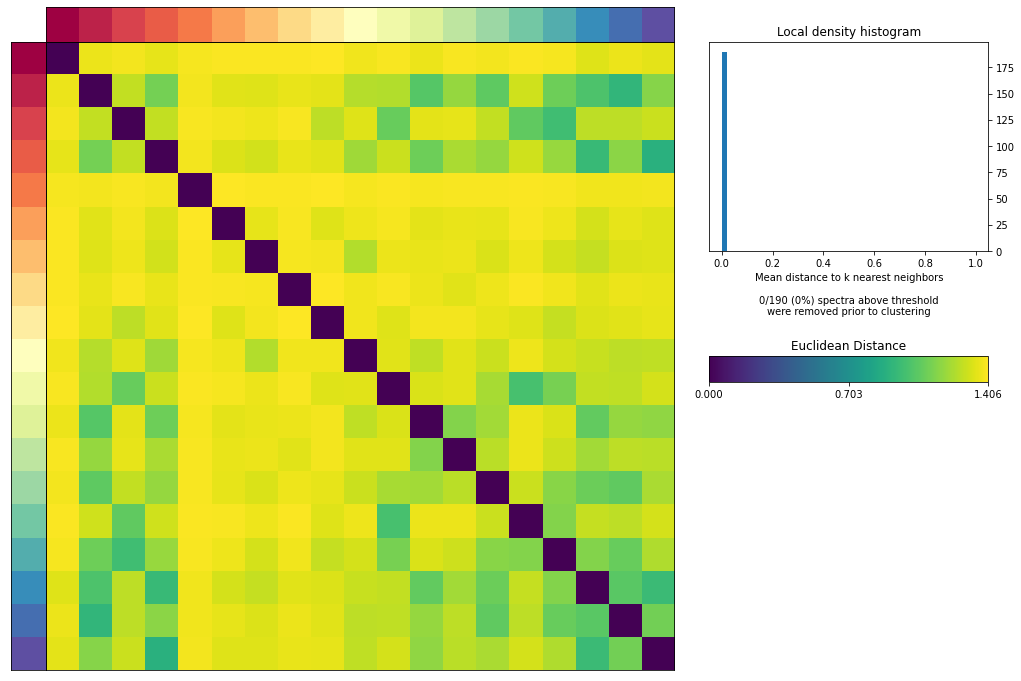

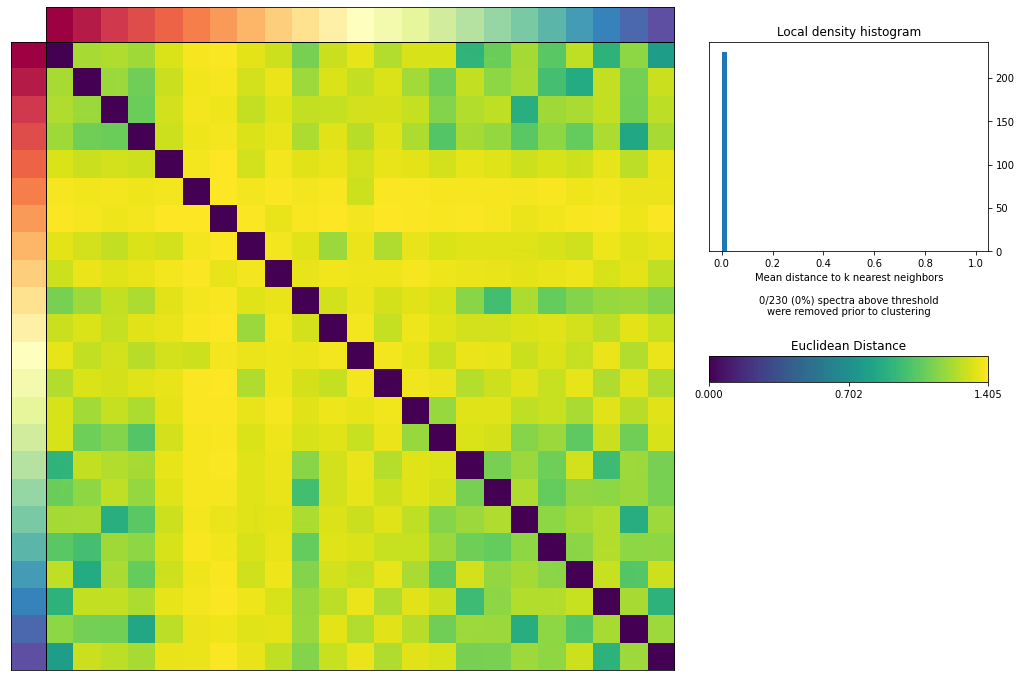

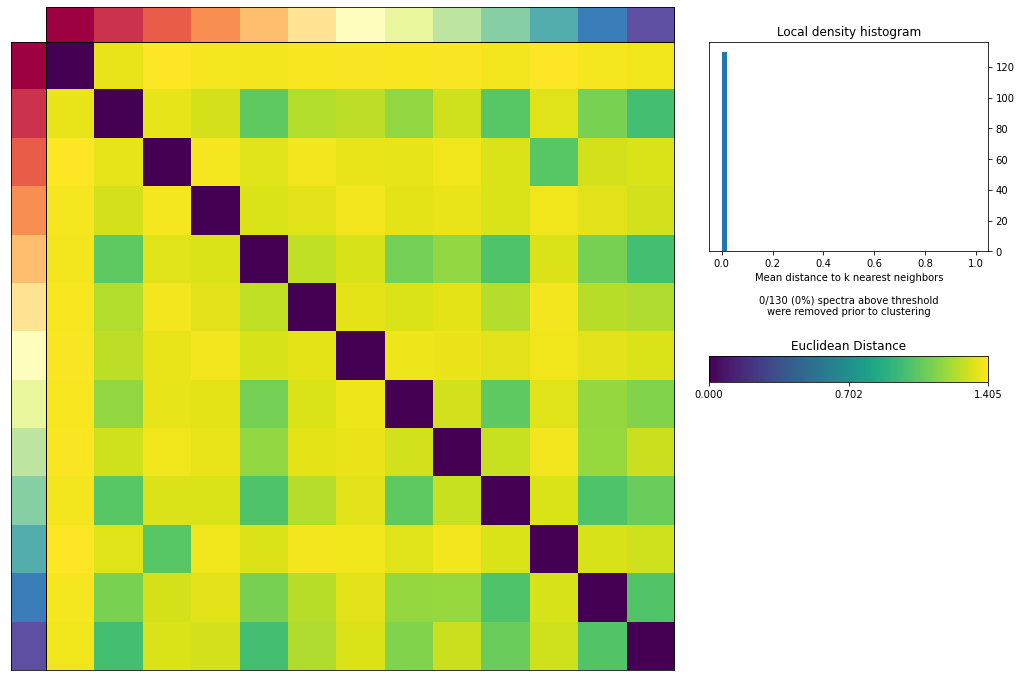

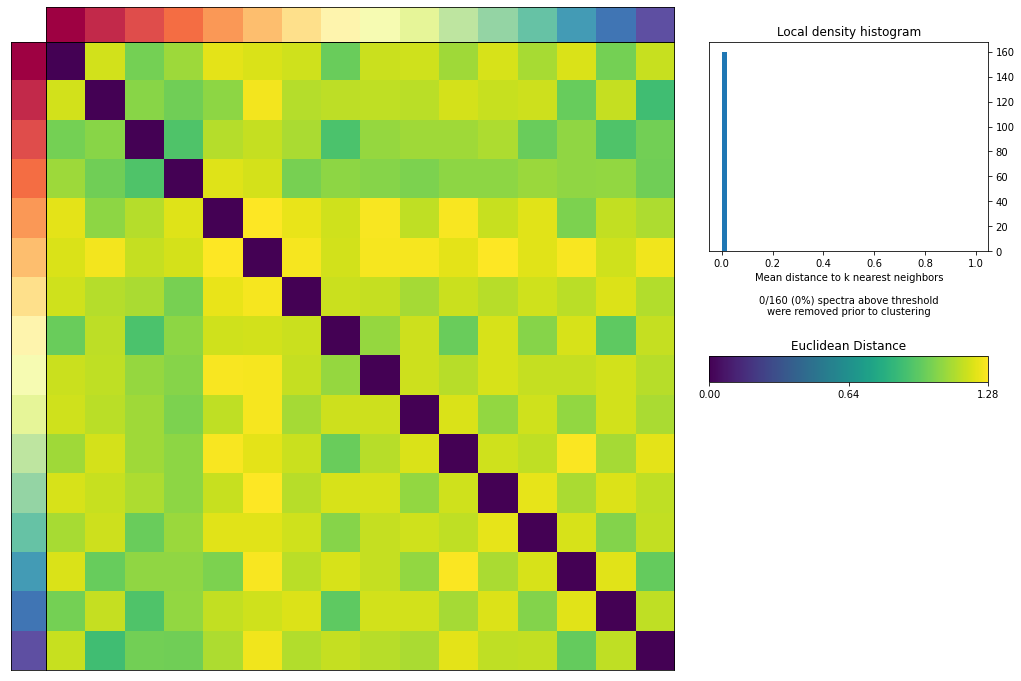

In [60]:
K_choice = {'LLN':24, 'SPL':21, 'BMA':23, 'JEJEPI':13, 'ILE':16}
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    print(o)
    cnmf_obj = cNMF(output_dir=cnmfdir, name=o)
    cnmf_obj.consensus(k=K_choice[o], density_threshold=2.0)
    

In [61]:
K_choice = {'LLN':24, 'SPL':19, 'BMA':23, 'JEJEPI':13, 'ILE':16}
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    (usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o, cnmfdir, K_choice[o], 2.0)
    print(o)
    display(topgenes.head(20).T)
    print('\n\n')

LLN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,RPLP0,RPS6,RPS18,RPL4,RPL3,RPS12,RPL18A,RPL13,EEF1A1,RPS5,EEF1G,RPS2,RPS14,RPS8,PABPC1,RPSA,RPL10,RPL18,RPL14,RPLP1
GEP1,DNAJB1,HSPA1A,HSPA1B,JUN,DUSP1,HSP90AA1,HSPA8,HSPA6,HSPB1,HSP90AB1,NR4A1,DNAJA1,BAG3,FOS,RHOB,HSPE1,DNAJA4,PPP1R15A,HSPD1,UBB
GEP2,ACTB,PFN1,ACTG1,TMSB10,CORO1A,CFL1,GAPDH,S100A4,MYL6,TMSB4X,ARPC1B,SH3BGRL3,PPIA,MYL12A,RAC2,ARHGDIB,COTL1,CD52,S100A6,PPP1CA
GEP3,RPS20,RPL23,RPS11,RPL13A,IGKC,RPS10,RPL27A,JCHAIN,MALAT1,RPL21,TRAC,RPS29,RPL7,RPL9,MT-ND4,IGHA1,RPS17,IGHM,ZFP36L2,JUND
GEP4,FOXP3,LINC01943,IL2RA,IL32,TIGIT,MIR4435-2HG,TNFRSF4,CTLA4,TNFRSF1B,TNFRSF18,IKZF2,CCR8,CYTOR,HLA-A,RGS1,ICA1,RTKN2,CARD16,ENTPD1,GBP5
GEP5,GZMK,CCL5,CST7,GZMA,CD8A,GZMH,NKG7,LYAR,DTHD1,HLA-DRB1,KLRG1,CD74,KLRK1,HLA-DPA1,HLA-DPB1,SLAMF7,HLA-B,HCST,CD8B,HLA-C
GEP6,NME1,NPM1,SRM,ENO1,C1QBP,RAN,EIF5A,PPP1R14B,GAL,FABP5,PRMT1,NME2,MRTO4,EBNA1BP2,NCL,CCT6A,PAICS,TPI1,DCTPP1,HMGA1
GEP7,CD200,PDCD1,LINC01480,DRAIC,MAP7,MS4A6A,TOX2,RGS4,PVALB,TNC,CXCL13,TOX,IL21,ICA1,PHEX,IGFBP4,LHFPL6,KSR2,CPM,GNG4
GEP8,SFTPB,SFTPC,SFTPA2,ELANE,PRTN3,SFTPA1,AZU1,MPO,WFDC2,SLPI,CTSG,TMEM125,PPP1R27,RPS27,EEF1A1,PCBP2,MT-ND4L,RPL35A,RPS28,S100A8
GEP9,FCER1G,TYROBP,KLRD1,KLRF1,NKG7,CLIC3,IL2RB,CTSW,SH2D1B,GNLY,XCL2,CMC1,KLRC1,CD160,CCL3,FGR,XCL1,NCAM1,LAT2,SPRY2





SPL


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,RPS3A,RPL13,RPS8,RPS13,RPL32,RPS14,RPS12,RPS6,RPL9,RPS5,RPS23,RPL11,RPL30,RPL19,EEF1B2,RPL7,RPL34,RPL18,RPS25,RPS16
GEP1,CCL5,CD8A,CD8B,HLA-DPA1,HLA-DRB1,GZMK,HLA-DPB1,KLRG1,TRGC2,HLA-C,PTPRC,CD3D,GZMH,LYAR,HCST,CD3E,KLRK1,CD74,GZMA,HLA-A
GEP2,FOSB,CD69,PPP1R15A,NFKBIA,JUN,ZFP36,FOS,DUSP1,NFKBIZ,KLF6,TNFAIP3,EGR1,MCL1,IER2,JUND,BTG2,BTG1,CSRNP1,H3F3B,IER5
GEP3,GZMB,FGFBP2,GNLY,SPON2,PRF1,FCGR3A,NKG7,AKR1C3,IGFBP7,ADGRG1,EFHD2,CD247,CYBA,PRSS23,CX3CR1,PLAC8,HOPX,CST7,CTSW,TTC38
GEP4,IL2RB,FCER1G,GSTP1,TYROBP,CD7,CMC1,IFITM2,LAT2,CD63,KLRF1,MATK,CD160,ADGRG3,KLRC1,CD38,SPRY2,LDB2,CLIC3,CCL3,TRDC
GEP5,S100A4,CD52,S100A6,S100A10,S100A11,TMSB10,LTB,CRIP1,EMP3,SH3BGRL3,FUT7,ITGB1,AQP3,ANXA2,LGALS3,IL32,NPDC1,LGALS1,CTSH,TIMP1
GEP6,HSPA1A,DNAJB1,HSPA1B,HSP90AA1,HSPE1,HSPA8,HSPD1,CACYBP,HSPH1,HSP90AB1,BAG3,HSPA6,HSPB1,DNAJA1,FKBP4,ZFAND2A,DNAJB4,DNAJA4,RGS2,SERPINH1
GEP7,CTLA4,ICA1,FOXP3,TBC1D4,CD27,TIGIT,ICOS,TRIB1,MAGEH1,LINC01943,RTKN2,ITM2A,FBLN7,TNFRSF4,IL2RA,BATF,CD200,IL21,CORO1B,F5
GEP8,NME1,GINS2,TNFRSF8,ENO1,GAPDH,NME2,C1QBP,RAN,ACTB,ACTG1,SRM,YBX1,PRDX1,RANBP1,TXN,PSMA7,PFN1,MIF,NPM1,EIF5A
GEP9,SOX4,SHD,KIT,IL1R1,ADGRD1,SPINK2,DPPA4,LINGO4,RORC,NEGR1,LST1,LTC4S,SCN1B,EMID1,PRKG1,AFF3,PCDH9,SRGAP3,ITM2C,TNFSF11





BMA


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,LEF1,CCR7,RPS13,RPS3A,RPL9,SOCS3,RPS8,RPL32,RPL11,RPL13,RPS5,RPL7,SELL,RPS12,TCF7,RPL19,RPL30,PABPC1,RPS25,RPS14
GEP1,PRF1,GZMB,SPON2,NKG7,FCGR3A,CD247,FCER1G,FGFBP2,GNLY,TYROBP,IGFBP7,AKR1C3,CYBA,ITGB2,EFHD2,KLRF1,CST7,CLIC3,PLAC8,HAVCR2
GEP2,GZMH,ITGB1,CD52,TRAV6,CD8B,PATL2,TRGC2,PROK2,CD8A,LINC02446,CES1,CD3G,PTPRC,S100A4,HLA-C,C12orf75,AHNAK,HLA-DPB1,CD2,ZEB2
GEP3,GZMK,CD74,HLA-DRB1,RGS1,CMC1,HLA-DQB1,HLA-DPA1,HLA-DQA1,CRTAM,CCL5,PIK3R1,HLA-DRA,HLA-DRB5,SH2D1A,HLA-DPB1,DUSP2,TUBA4A,ITM2A,HLA-DMA,TNIP3
GEP4,FOS,ZFP36,IER2,NFKBIA,DUSP1,PPP1R15A,FOSB,JUN,CD69,BTG2,EGR1,JUND,TNFAIP3,CXCR4,NR4A2,MAFF,JUNB,BTG1,TSC22D3,MCL1
GEP5,RPLP1,RPS2,NME2,RPL23A,RPL15,RPS18,RPL37A,RPL36A,RPSA,ACTG1,RPL17,RPL26,RPS6,RPL7A,RPL10A,ACTB,RPL27,RPL3,RPL35,RPL41
GEP6,IL7R,LTB,CCR6,CCR4,AQP3,TTC39C-AS1,WDR86-AS1,KLF6,CD40LG,GPR183,ADAM19,BIRC3,VIM,CD82,ZFP36L2,CDC14A,PAG1,ADAM23,LGALS3,ANXA1
GEP7,SPTSSB,KLRC1,IL2RB,ADGRG3,IFITM3,CMC1,PPP1R9A,NCAM1,CD7,RASSF8,SPRY2,IGFBP4,XCL1,IFITM2,MATK,SELL,TNFRSF11A,KIR2DL4,FCER1G,IL18
GEP8,HSPA1A,HSPA1B,DNAJB1,HSP90AA1,HSPE1,HSPA6,HSPA8,HSP90AB1,BAG3,HSPD1,HSPH1,HSPB1,RHOB,CACYBP,DNAJA1,RGS2,DNAJA4,UBC,JUN,NR4A1
GEP9,HBB,HBA2,HBA1,ALAS2,MT-ND3,MT-ND4,MT-ATP6,MT-ND2,MT-ND1,SNCA,SLC25A37,MT-CYB,PDZK1IP1,MT-CO2,HBM,HBG2,HBQ1,LYAR,IL7R,IGKC





JEJEPI


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,EZR,SYTL3,CREM,SARAF,RANBP2,AKAP13,FAM177A1,GSPT1,SMAP2,METRNL,NR3C1,JMY,ATP1B3,TSPYL2,FYN,ZFP36L2,IL7R,CNOT6L,TSC22D3,PDE4D
GEP1,RPS29,RPL21,RPL13A,RPS21,TRAC,RPS10,RPL34,RPS27,RPS27A,IGKC,RPL9,RPL37A,RPS3A,RPS11,IGHA1,RPS28,RPS20,RPLP2,RPL32,RPL27A
GEP2,ACTB,PFN1,TMSB4X,CD8B,IFITM1,RAC2,CD8A,CD3D,CAPG,B2M,CFL1,CD3E,SH3BGRL3,CALR,CORO1A,HLA-C,NKG7,ACTG1,CD244,PSME2
GEP3,HSPA1A,HSP90AA1,DNAJB1,HSPH1,NR4A1,HSPD1,HSPE1,HSP90AB1,DNAJA1,UBC,HSPA1B,PPP1R15A,JUN,DUSP1,UBB,DOK2,HSPB1,FOSB,HSPA6,BTG2
GEP4,FCER1G,GZMA,TYROBP,CD247,TNFRSF18,CD7,KRT81,KRT86,KLHL23,TRDC,GNLY,LAT2,KIR2DL4,GSTP1,SH2D1B,ADGRG3,B3GNT7,IL2RB,ZBTB16,SPRY2
GEP5,LTB,CD40LG,S100A4,IL4I1,LINC00892,CD28,CD4,TNFSF13B,TNFRSF25,IL23R,DPP4,SLAMF1,AQP3,CCR6,SPOCK2,RORC,KLF4,CA2,RPLP1,MAF
GEP6,MT-CO1,MT-ND5,MT-ND1,MT-CYB,MT-CO3,MT-CO2,MT-ND2,MT-ND4L,MT-ATP6,MT-ATP8,MT-ND6,MT-ND3,MT-ND4,MTRNR2L12,APOA4,APOA1,IKZF2,MALAT1,PIGR,PHGR1
GEP7,ELANE,PRTN3,CTSG,AZU1,MPO,SFTPA2,SFTPC,TRBV6-1,SFTPA1,RBP2,PPP1R27,FABP1,SFTPB,PHGR1,TRAV16,TRAV3,PRSS57,CEACAM6,ALDOB,S100A8
GEP8,IGLV2-14,IGHV1-46,GNG8,LINC01281,ARMH1,IGHV2-5,CPA5,IGLV2-11,CCR7,LEF1,IGLC3,BEX3,IGLC2,UBXN10-AS1,RPS26,IGHA1,IGFBP4,SELL,CDCA7,RAMP1
GEP9,SORCS1,HOXA5,KIAA1211L,KIT,PCDH9,HOXA9,EBI3,KRT83,TNFSF11,B4GALNT1,LINC01644,NCR3,SOX4,APOL4,OPCML,IL4I1,VEGFA,LST1,LIF,IL23R





ILE


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
GEP0,ZFP36L2,IL7R,TSC22D3,CRYBG1,TXNIP,RPS29,CD55,ZFP36,EEF1A1,CXCR4,RPS3A,RPL10,RPL34,SMAP2,RPS27,FAM177A1,RPL14,JUNB,RPL35A,SMIM3
GEP1,SH3BGRL3,TMSB4X,ACTB,CD3D,CD52,PFN1,TRBV9,CD8A,SIT1,RAC2,CORO1A,CFL1,MYL12A,ACTG1,GZMM,CD8B,CAPG,COTL1,HLA-C,CCL5
GEP2,DNAJB1,HSPA1A,HSPA1B,HSP90AA1,HSPA8,DUSP1,HSP90AB1,ANXA1,JUN,UBB,DNAJA1,HSPH1,EGR1,CACYBP,MRPL18,BTG2,PPP1R15A,NR4A1,PTGES3,SERPINH1
GEP3,MT-CO1,MT-ND5,MT-CO2,MT-ND3,MT-ND4L,MT-ND4,MT-CO3,MT-ATP8,MT-ND1,MT-CYB,MT-ATP6,MT-ND6,MTRNR2L12,MACF1,MALAT1,MT-ND2,CBLB,SLC12A6,ITGA1,SMG1
GEP4,PRR5,LTB,IL4I1,CCL20,KIT,RUNX2,RORA,NECTIN2,RORC,AQP3,TLE1,IL22,CD40LG,S100A4,CA2,SPOCK2,SLC4A10,LINC01644,IL17A,IL17RE
GEP5,FCER1G,TYROBP,GZMA,CD7,KIR2DL4,CD247,KRT81,NCR2,TNFRSF18,CXXC5,IL2RB,GNLY,KRT86,TRDC,S100A13,FGR,LAT2,GSTP1,ACP5,HOPX
GEP6,GZMH,ITGB2,CST7,CMC1,KLF2,GZMK,SH2D1A,NKG7,RASA3,HLA-DQA1,HLA-DRB1,CCL3,YBX3,HLA-DRB5,PRF1,EOMES,TGFBR3,CCR4,ADGRG1,EMP3
GEP7,PHGR1,REG1A,SELENOP,ADIRF,ALDOB,REG1B,SERPINA1,FABP2,APOC3,APOA1,ANPEP,TMEM45B,CST3,C3orf85,S100A14,C2orf88,C19orf33,TSPAN8,SPINK1,PRAP1
GEP8,COL6A2,REC8,CTSF,SMC4,CRTAM,XCL2,SPECC1,PPOX,SHMT2,ENTPD1,MID1IP1,RPL7,EEF2,TCTN3,ATP5MC3,TIGIT,FANCI,AKAP5,IMPDH2,ZNF529-AS1
GEP9,DRAIC,LRRC61,IFT172,FAM89A,CHAF1A,CDT1,SUOX,BRCA2,MIF,CHEK1,NOL6,MTHFD1,GAMT,WDR75,TONSL,COTL1,MSANTD4,DRAXIN,GALE,CDCA7L


## Clustering across runs

In [19]:
cnmfdir = '../../Data/XTissueImmuneAtlas/PerTissue'
K_choice = {'LLN':20, 'SPL':19, 'BMA':23, 'JEJEPI':13, 'ILE':16}
all_spectra = []
label = []
for o in ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']:
    (usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o, cnmfdir, K_choice[o], 2.0)
    spectra.columns = [o + '_%d' % i for i in range(1, spectra.shape[1]+1)]
    all_spectra.append(spectra.T)
    label += [o]*K_choice[o]
    

In [23]:
all_spectra = pd.concat(all_spectra, axis=0)
label = pd.Series(label, index=all_spectra.index)

In [27]:
all_spectra_filt = all_spectra.loc[:,all_spectra.isnull().sum(axis=0)==0]

In [31]:
R = all_spectra_filt.T.corr()

In [42]:
tissues = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']
mapping = dict(zip(tissues, sns.color_palette("tab10")))
label_colors = [mapping[x] for x in label]

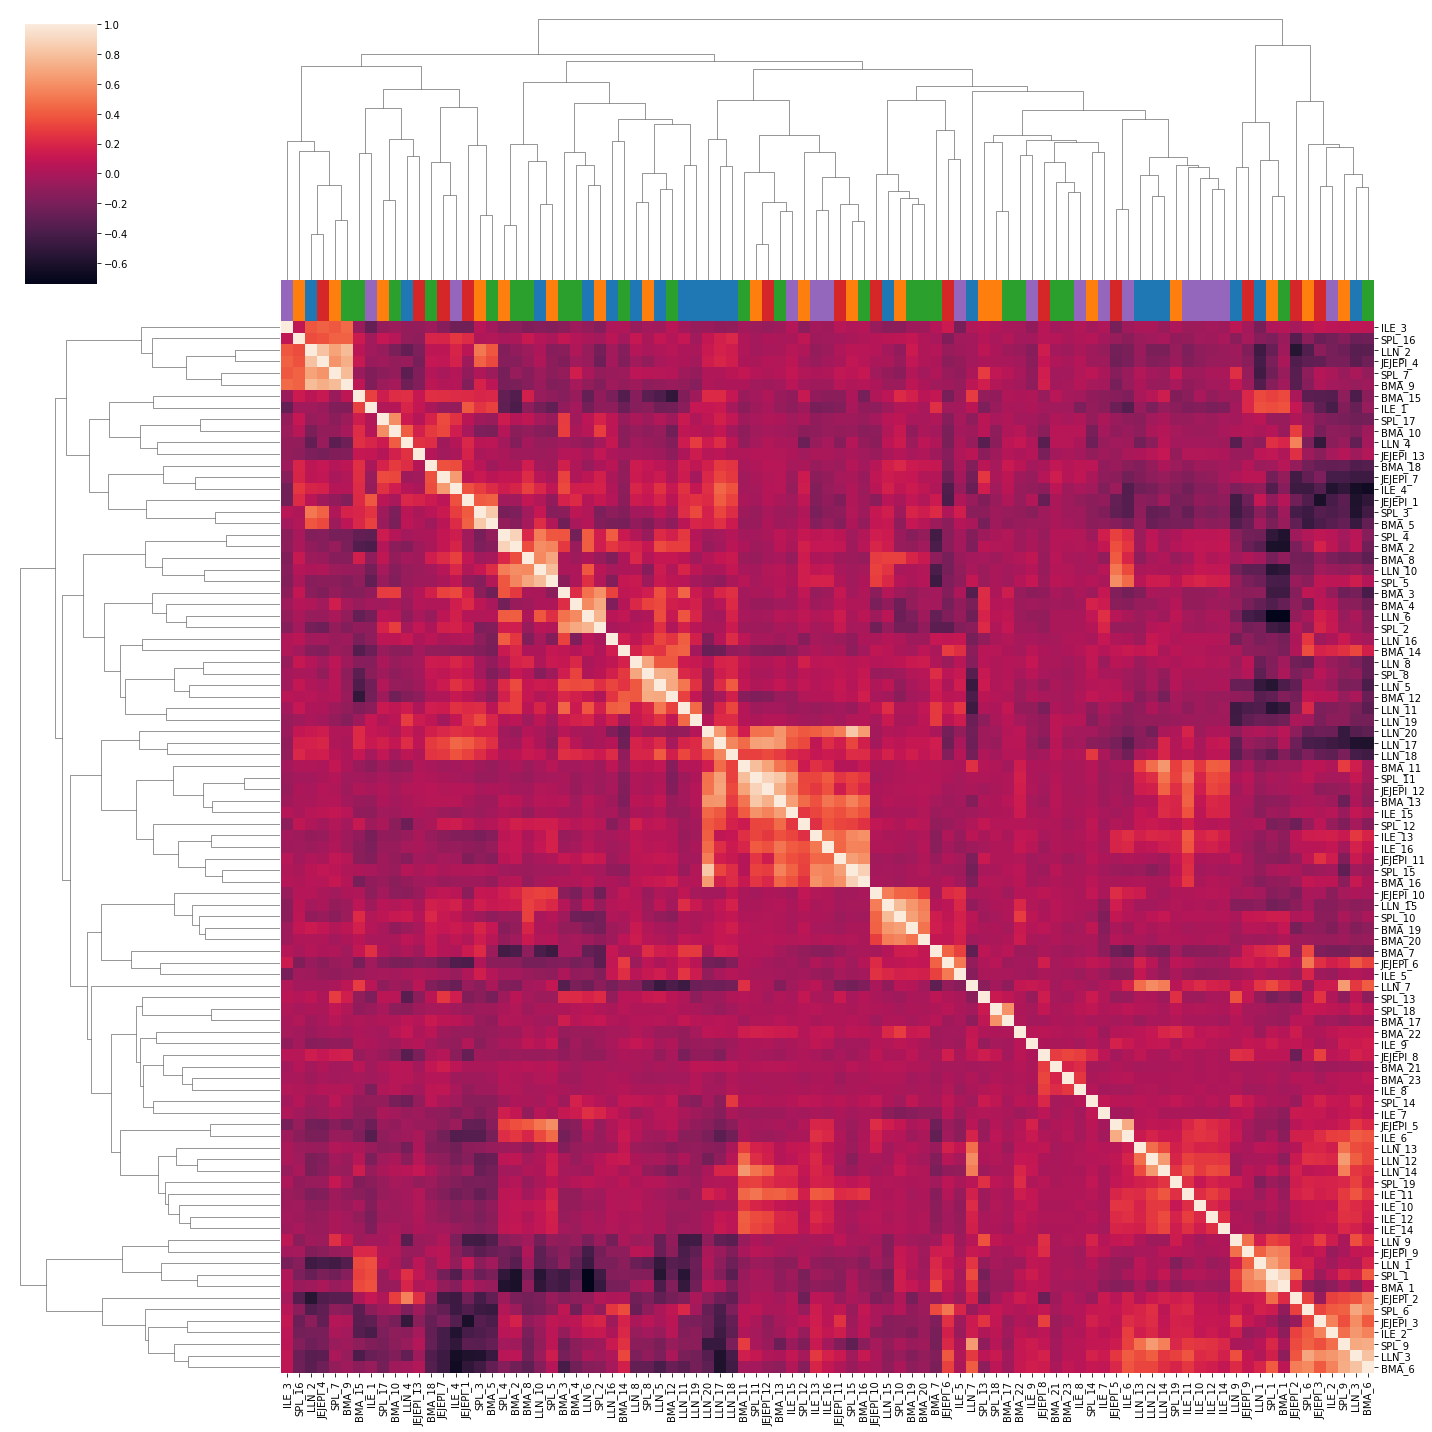

In [43]:
sns.clustermap(R, figsize=(20,20), xticklabels=True, yticklabels=True, col_colors=label_colors)

In [17]:
spectra

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
LINC01409,0.000054,-0.000053,-0.000245,-0.000246,0.000140,-0.000022,-9.595937e-06,1.109610e-04,0.000059,0.000018,0.000061,-8.445667e-06,-0.000021,5.750570e-07,0.000099,-0.000021,0.000111,0.000035,-0.000212,0.000034
FAM87B,-0.000041,-0.000105,0.000001,0.000203,0.000115,0.000017,-1.869680e-05,-7.244561e-06,-0.000029,0.000102,0.000057,7.055472e-07,-0.000010,-8.184219e-06,0.000016,0.000115,-0.000012,0.000033,-0.000109,-0.000036
LINC01128,0.000037,0.000269,-0.000136,-0.000431,-0.000202,-0.000268,1.863994e-05,3.813059e-05,0.000359,0.000268,-0.000038,-2.078892e-06,-0.000004,-1.045476e-05,0.000047,-0.000014,0.000062,0.000016,0.000069,0.000014
LINC00115,0.000016,0.000028,-0.000078,-0.000310,-0.000024,-0.000014,-6.781607e-06,3.656365e-05,0.000293,0.000130,0.000018,-1.760256e-05,-0.000008,-1.393151e-06,0.000183,-0.000011,0.000026,-0.000013,-0.000095,0.000018
FAM41C,-0.000026,-0.000168,-0.000042,0.000541,0.000031,-0.000003,3.014212e-07,-2.394067e-06,-0.000371,-0.000038,0.000022,8.588842e-07,-0.000023,4.582244e-06,0.000223,0.000027,0.000012,-0.000010,0.000274,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,0.000488,-0.003120,-0.001201,0.004737,-0.000371,0.001096,-1.108578e-04,-2.266087e-04,-0.002699,0.000300,0.000346,4.041008e-05,-0.000192,5.225696e-05,0.000526,0.000112,0.000501,0.000234,-0.000137,0.000359
MT-ND5,0.000881,-0.001636,-0.001268,-0.002131,0.000525,0.001671,-1.604064e-04,9.666591e-05,0.001169,0.000239,0.000360,4.060700e-05,-0.000085,2.218345e-05,0.000360,0.000010,0.000592,0.000395,-0.000775,0.000338
MT-ND6,0.000926,-0.000099,-0.000941,-0.003229,0.000263,-0.000064,-5.115621e-05,3.864336e-04,-0.000380,-0.000070,0.000013,3.436390e-05,-0.000009,1.428967e-05,-0.000027,-0.000070,0.000418,0.000233,-0.000803,0.000286
MT-CYB,0.000772,-0.003368,-0.001177,0.002436,-0.000086,0.001433,-1.481205e-04,3.571099e-06,-0.001665,0.000063,0.000375,3.419505e-05,-0.000197,3.383330e-06,0.000282,0.000032,0.000542,0.000239,0.000031,0.000353


## Random initialization

In [6]:
cnmfdir = '../../Data/XTissueImmuneAtlas/PerTissue'

orgs = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'BLD', 'JEJLP', 'MLN', 'LIV',
                  'LNG', 'ILE', 'SKM', 'DUO', 'OME', 'THY', 'CAE', 'TCL',
                  'SCL']

orgs_to_run = ['LLN', 'SPL', 'BMA', 'JEJEPI', 'ILE']
orgs_to_run = ['LLN', 'ILE']

total_workers = 200
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for o in orgs_to_run:
    name = o + '_RandomInit'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_count_fn = os.path.join(cnmfdir,  '%s.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % o)
    cnmf_tpm_fn = os.path.join(cnmfdir, '%s.tp10k.filt.h5ad' % o)
    hvg_fn = os.path.join(cnmfdir,  '%s.counts.filt.hvgs.txt' % o)
    cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(5, 25), n_iter=10,
                tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn)
    
    jname = name
    cnmfout = os.path.join(cnmfdir, name, 'log')

    if not os.path.exists(cnmfout): os.mkdir(cnmfout)

    for i in range(total_workers):
        cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
        e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
        out = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
        bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=out, other=other, cmd=cmd)
        print(bsub_cmd)
        !{bsub_cmd}

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
bsub -q short -J LLN_RandomInit -o ../../Data/XTissueImmuneAtlas/PerTissue/LLN_RandomInit/log/LLN_RandomInit.0.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/LLN_RandomInit/log/LLN_RandomInit.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name LLN_RandomInit --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 200 --worker-index 0"
Job <456455> is submitted to queue <short>.
bsub -q short -J LLN_RandomInit -o ../../Data/XTissueImmuneAtlas/PerTissue/LLN_RandomInit/log/LLN_RandomInit.1.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/LLN_RandomInit/log/LLN_RandomInit.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "sel

In [49]:
orgs_to_run = ['ILE']

total_workers = 200
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for o in orgs_to_run:
    name = o + '_RandomInit'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_count_fn = os.path.join(cnmfdir,  '%s.counts.filt.VarNorm.HVG.HarmonyGeneCorrect.h5ad' % o)
    cnmf_tpm_fn = os.path.join(cnmfdir, '%s.tp10k.filt.h5ad' % o)
    hvg_fn = os.path.join(cnmfdir,  '%s.counts.filt.hvgs.txt' % o)
    cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(5, 25), n_iter=10,
                tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn)
    
    jname = name
    cnmfout = os.path.join(cnmfdir, name, 'log')

    if not os.path.exists(cnmfout): os.mkdir(cnmfout)

    for i in [88, 93, 96, 102, 108, 110, 119]:
        cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
        e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
        out = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
        bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=out, other=other, cmd=cmd)
        print(bsub_cmd)
        !{bsub_cmd}

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


bsub -q short -J ILE_RandomInit -o ../../Data/XTissueImmuneAtlas/PerTissue/ILE_RandomInit/log/ILE_RandomInit.88.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/ILE_RandomInit/log/ILE_RandomInit.88.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name ILE_RandomInit --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 200 --worker-index 88"
Job <462092> is submitted to queue <short>.
bsub -q short -J ILE_RandomInit -o ../../Data/XTissueImmuneAtlas/PerTissue/ILE_RandomInit/log/ILE_RandomInit.93.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/ILE_RandomInit/log/ILE_RandomInit.93.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; c

In [63]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
total_workers = 200
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p =  run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)

LLN
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
ILE
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizatio

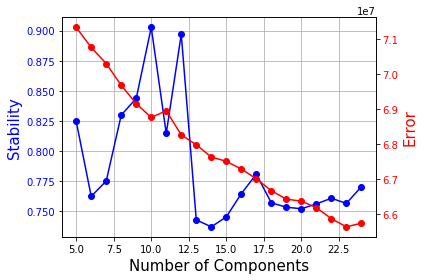

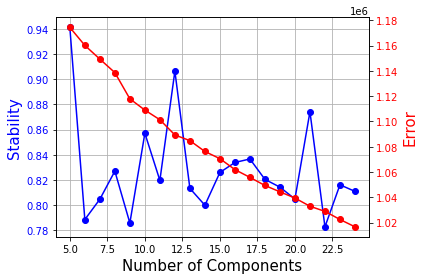

In [64]:
for o in ['LLN', 'ILE']:
    print(o)
    name = o + '_RandomInit'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_obj.combine()
    cnmf_obj.k_selection_plot()

LLN
ILE


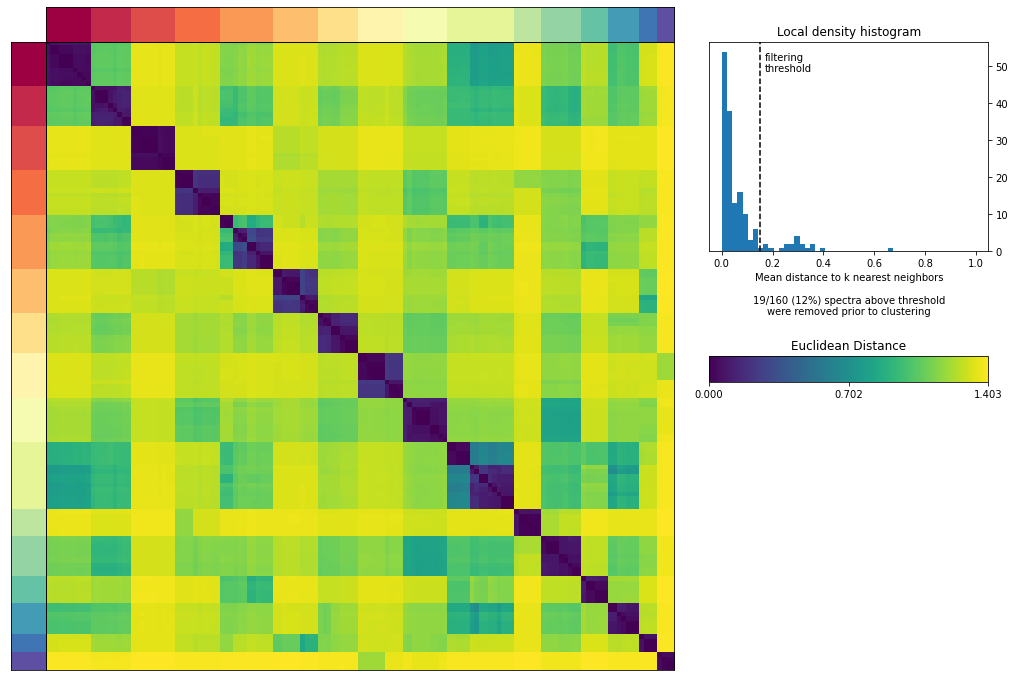

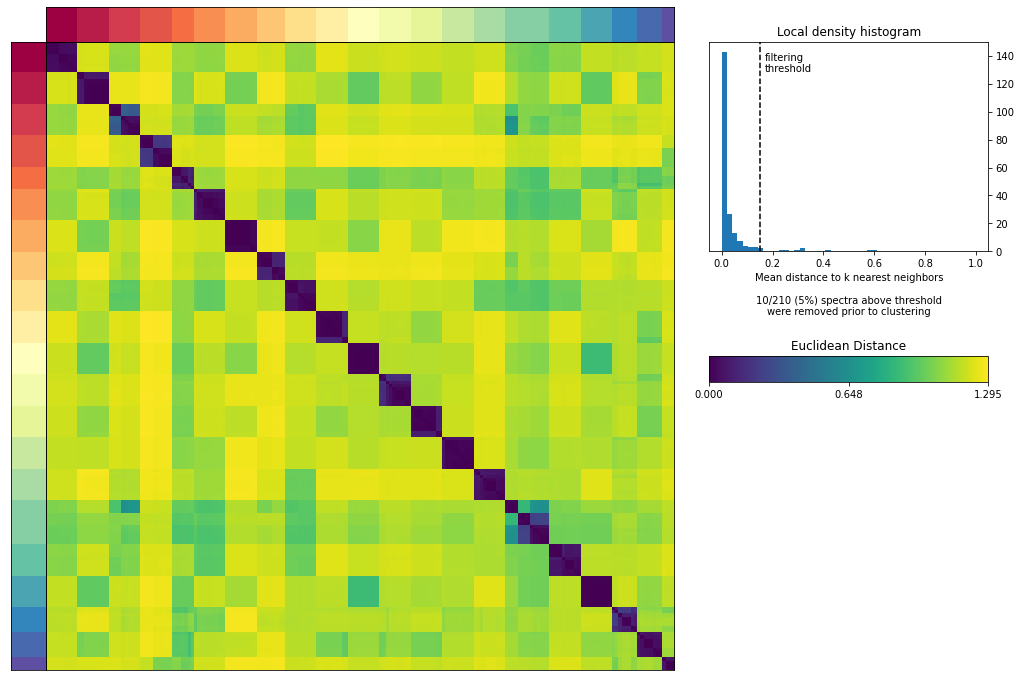

In [65]:
K_choice = {'LLN':16, 'SPL':19, 'BMA':23, 'JEJEPI':13, 'ILE':21}
for o in ['LLN', 'ILE']:
    print(o)
    name = o + '_RandomInit'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_obj.consensus(k=K_choice[o], density_threshold=0.15)

In [ ]:
o = 'LLN'
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o + '_RandomInit', cnmfdir, 16, 0.15)
topgenes.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
GEP0,RPS6,RPS5,RPL18A,RPS23,RPS12,RPL13,RPS14,RPL32,RPS8,RPLP0,RPL29,RPL18,RPL3,EEF1G,RPL19
GEP1,TNFAIP3,KLF6,ZFP36,ANXA1,NFKBIA,IL7R,ZFP36L2,LMNA,RORA,MCL1,VIM,AHNAK,SRGN,EIF1,CCR4
GEP2,HSPA1A,DNAJB1,HSPA1B,JUN,HSP90AA1,HSPA6,HSPB1,HSPA8,BAG3,NR4A1,DUSP1,HSP90AB1,RHOB,HSPE1,DNAJA4
GEP3,ACTB,PFN1,ACTG1,TMSB10,CFL1,GAPDH,S100A4,CORO1A,TMSB4X,MYL6,ARPC1B,SH3BGRL3,COTL1,PPIA,RAC2
GEP4,RPL23,RPS20,RPS11,RPL13A,IGKC,RPS10,RPL27A,RPL21,JCHAIN,RPL7,MALAT1,RPS29,TRAC,RPL9,MT-ND4
GEP5,FOXP3,TIGIT,CTLA4,LINC01943,ICA1,IL2RA,MIR4435-2HG,TNFRSF4,IKZF2,TNFRSF1B,IL32,TNFRSF18,MAGEH1,HLA-A,TBC1D4
GEP6,NME1,NPM1,BATF3,PPP1R14B,C1QBP,SRM,RAN,EIF5A,ENO1,GINS2,PAICS,NCL,NME2,DCTPP1,MRTO4
GEP7,GZMK,CCL5,GZMA,CST7,CD8A,GZMH,NKG7,HLA-DRB1,HLA-DPA1,CD74,HLA-DPB1,DTHD1,LYAR,KLRG1,PLEK
GEP8,FCER1G,TYROBP,KLRD1,KLRF1,NKG7,CLIC3,IL2RB,CTSW,CMC1,SH2D1B,GNLY,XCL2,CD160,KLRC1,CCL3
GEP9,SFTPB,SFTPC,SFTPA2,ELANE,PRTN3,SFTPA1,AZU1,MPO,WFDC2,SLPI,CTSG,TMEM125,PPP1R27,RPS27,PCBP2


In [67]:
o = 'ILE'
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o + '_RandomInit', cnmfdir, 21, 0.15)
topgenes.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
GEP0,CRYBG1,IL7R,CD55,ZFP36L2,TXNIP,TSC22D3,SMIM3,ZFP36,CXCR4,FAM177A1,PIK3R1,HERPUD1,RPS29,HIST1H1D,SMAP2
GEP1,SH3BGRL3,TRBV9,ACTB,TMSB4X,CD3D,SIT1,CD52,PFN1,RAC2,CORO1A,CD8A,MYL12A,ACTG1,GZMM,CAPG
GEP2,DNAJB1,HSPA1A,HSPA1B,HSP90AA1,HSPA8,DUSP1,NR4A1,EGR1,HSP90AB1,JUN,HSPH1,BTG2,ANXA1,PPP1R15A,DNAJA1
GEP3,LTB,CD40LG,IL17A,KLRB1,S100A4,NR1D1,CTSH,IFI44L,ICOS,PRR5,CXCR6,TNFSF13B,IL12RB1,HLF,IL22
GEP4,RPL36,TNFRSF4,SOCS3,RPL10,CCR4,FXYD5,RPL34,RPS3A,RPS8,RPS13,RPS28,RPL9,LMNA,RPL11,RPS27
GEP5,MT-CO3,MT-CO1,MT-ND1,MT-ND4,MT-ND5,MT-ND3,MT-CO2,MT-CYB,ATP8B4,MT-ATP8,MT-ATP6,SIX4,MT-ND4L,BCL2L11,MT-ND6
GEP6,FCER1G,TYROBP,NCR2,KIR2DL4,GZMA,CD7,KRT81,TRDC,CXXC5,S100A13,ACP5,CD247,GSTP1,GNLY,KRT86
GEP7,GZMH,ITGB2,CST7,NKG7,CMC1,GZMK,SH2D1A,RASA3,HLA-DQA1,HLA-DRB1,KLF2,CCL3,PRF1,HLA-DRB5,YBX3
GEP8,ALDOC,IL4I1,KIT,PRR5,FAM174B,RORC,CD83,MATN2,NECTIN2,SPOCK2,AFF3,CCL20,SLC4A10,ZBTB16,GSN
GEP9,SGPP1,PKP4,CCNE2,AMD1,TSC22D2,ZNF808,RSPH3,NKIRAS1,TRPM2,FBXO46,PIK3C2B,TRBV4-1,UBC,EGR2,TSPYL2


In [37]:
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o, cnmfdir, 14, 2.0)

<AxesSubplot:>

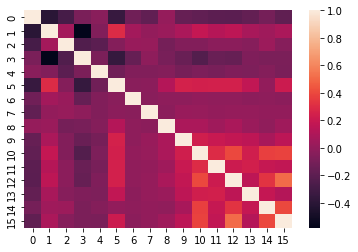

In [35]:
sns.heatmap(spectra.corr())

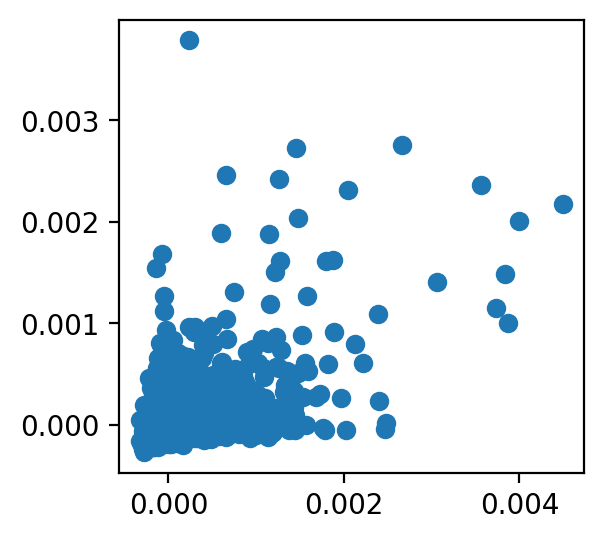

In [34]:
x = 14
y = 15
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(spectra[x], spectra[y])

In [38]:
topgenes.head(20)

,GEP0,GEP1,GEP2,GEP3,GEP4,GEP5,GEP6,GEP7,GEP8,GEP9,GEP10,GEP11,GEP12,GEP13
0,ZFP36L2,SH3BGRL3,LTB,MT-CO1,FCER1G,ITGB2,PHGR1,COL6A2,HMGN2,TYMS,CDCA8,CDCA7,HIST1H4C,HIST1H4B
1,IL7R,TMSB4X,PRR5,MT-ND5,TYROBP,GZMH,REG1A,REC8,TYMS,GINS2,CENPF,MCM2,AURKB,CDK1
2,TSC22D3,MYL12A,IL4I1,MT-CO2,GZMA,KLF2,SELENOP,SMC4,GGH,TK1,TOP2A,UHRF1,CDKN3,HIST1H1B
3,CRYBG1,CD52,CCL20,MT-ND3,CD7,CST7,ADIRF,CTSF,STMN1,UHRF1,MKI67,CENPU,TOP2A,HIST1H2BN
4,CD55,HSPA1B,CD40LG,MT-ND4L,KIR2DL4,GZMK,ALDOB,CRTAM,TUBA1B,MCM8,KNSTRN,GLA,STMN1,CENPF
5,TXNIP,ACTB,RUNX2,MT-ND4,KRT81,SH2D1A,REG1B,XCL2,TUBB,ID3,CCNB1,RAD51D,MKI67,MKI67
6,RPS29,LAT,KLRB1,MT-CO3,CD247,CMC1,SERPINA1,SPECC1,CDKN3,CDCA7,CDKN3,MSH6,TUBA1B,HMGN2
7,ZFP36,SIT1,AQP3,MT-ATP8,NCR2,RASA3,FABP2,ENTPD1,DPYSL2,DRAIC,KPNA2,CHAF1B,CDK1,HIST1H4C
8,EEF1A1,PFN1,RORC,MT-ND1,CXXC5,NKG7,APOC3,ATP5MC3,ZWINT,DCTPP1,HMGB3,NETO2,PSMC3IP,CDCA8
9,CXCR4,CORO1A,IL17A,MT-CYB,TNFRSF18,EMP3,APOA1,SHMT2,FANCI,MCM5,TUBA1B,ZNF768,CDT1,AURKB


In [51]:
adata

AnnData object with n_obs × n_vars = 216611 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range'
    var: 'gene'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# Uncorrected

In [69]:
for o in ['ILE']:
    name = o +'_Uncorrected'
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    cnmf_count_fn = os.path.join(cnmfdir, '%s.counts.filt.h5ad' % o)
    cnmf_tpm_fn = os.path.join(cnmfdir, '%s.tp10k.filt.h5ad' % o)
    hvg_fn = os.path.join(cnmfdir,  '%s.counts.filt.hvgs.txt' % o)
    cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=np.arange(5, 25), n_iter=10,
                tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn)

Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [72]:
sc.read(cnmf_count_fn).X.todense()

Only considering the two last: ['.filt', '.h5ad'].
Only considering the two last: ['.filt', '.h5ad'].


matrix([[ 0.,  0.,  0., ..., 13.,  2., 34.],
        [ 0.,  1.,  0., ..., 10.,  3., 47.],
        [ 0.,  0.,  0., ..., 15.,  1., 35.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  0., 39.],
        [ 0.,  0.,  0., ..., 15.,  3., 51.],
        [ 0.,  0.,  0., ...,  4.,  0., 32.]], dtype=float32)

In [49]:
total_workers = 200
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

if not os.path.exists(cnmfout): os.mkdir(cnmfout)

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J ILE_Uncorrected -o ../../Data/XTissueImmuneAtlas/PerTissue/ILE_Uncorrected/log/ILE_Uncorrected.0.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/ILE_Uncorrected/log/ILE_Uncorrected.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name ILE_Uncorrected --output-dir ../../Data/XTissueImmuneAtlas/PerTissue --total-workers 200 --worker-index 0"
Job <383763> is submitted to queue <short>.
bsub -q short -J ILE_Uncorrected -o ../../Data/XTissueImmuneAtlas/PerTissue/ILE_Uncorrected/log/ILE_Uncorrected.1.out.txt -e ../../Data/XTissueImmuneAtlas/PerTissue/ILE_Uncorrected/log/ILE_Uncorrected.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREAD

In [50]:
! bjobs

No unfinished job found


In [51]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.


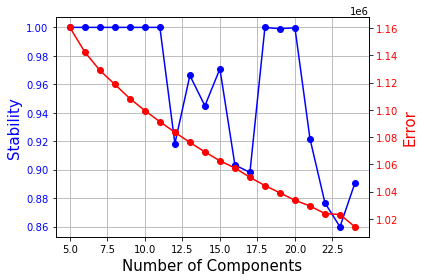

In [52]:
cnmf_obj.k_selection_plot()

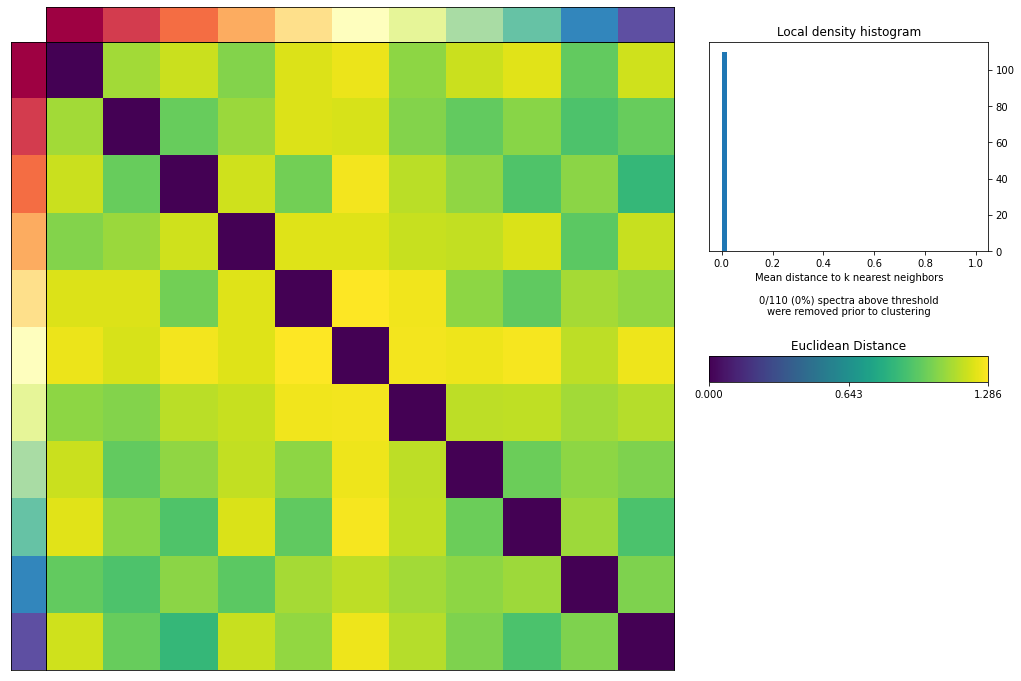

In [53]:
cnmf_obj.consensus(k=11, density_threshold=2.0)

In [67]:
def get_cnmf_results(name, cnmfdir, K, ldthresh):
    cnmf_obj = cNMF(output_dir=cnmfdir, name=name)
    scorefn = cnmf_obj.paths['gene_spectra_score__txt'] % (K, str(ldthresh).replace('.', '_'))
    usagefn = cnmf_obj.paths['consensus_usages__txt'] % (K, str(ldthresh).replace('.', '_'))
    genefn = cnmf_obj.paths['nmf_genes_list']
    hvgs = open(genefn).read().split('\n')
    spectra = pd.read_csv(scorefn, sep='\t', index_col=0).T
    usage = pd.read_csv(usagefn, sep='\t', index_col=0)
    usage = usage.div(usage.sum(axis=1), axis=0)

    orig = np.array(usage.sum(axis=0).sort_values(ascending=False).index)
    remap = dict(zip(orig, np.arange(len(orig))))

    usage = usage.rename(columns=remap).sort_index(axis=1)

    spectra.columns = [str(x) for x in spectra.columns]
    spectra = spectra.rename(columns=remap).sort_index(axis=1)
    
    top_genes = []
    ngenes = 100
    for gep in spectra.columns:
        top_genes.append(list(spectra.sort_values(by=gep, ascending=False).index[:ngenes]))
        
    
    top_genes = pd.DataFrame(top_genes, index=['GEP%d' % i for i in spectra.columns]).T
    return(usage, spectra, hvgs, top_genes, remap)

o = 'ILE'
(usage, spectra, hvgs, topgenes, remap) = get_cnmf_results(o+'_Uncorrected', cnmfdir, 11, 2.0)

In [68]:
topgenes

,GEP0,GEP1,GEP2,GEP3,GEP4,GEP5,GEP6,GEP7,GEP8,GEP9,GEP10
0,ZFP36L2,SH3BGRL3,FCER1G,LTB,COL6A2,PHGR1,TYMS,CDCA7,CDCA8,HIST1H4C,HIST1H4B
1,TSC22D3,HSPA1B,GZMA,IL4I1,REC8,REG1A,HMGN2,UHRF1,CENPF,AURKB,CDK1
2,IL7R,DNAJB1,TYROBP,PRR5,SMC4,SELENOP,GGH,TYMS,TOP2A,CDKN3,HIST1H1B
3,CRYBG1,LAT,KIR2DL4,RORC,CTSF,REG1B,STMN1,GINS2,MKI67,TOP2A,HIST1H2BN
4,TXNIP,MYL12A,IL2RB,CD40LG,CRTAM,ADIRF,TUBA1B,MCM2,CCNB1,STMN1,CENPF
...,...,...,...,...,...,...,...,...,...,...,...
95,DUSP2,TBCB,IKZF3,PIM1,SYCP2,PGM3,ECI1,PYGB,CDC25B,SYT5,NTHL1
96,CH25H,PSMB10,GZMK,BCL7C,ZMYM4,ZNF513,LDHA,WDR89,DHFR,C19orf47,HIST1H2BJ
97,RPL11,CALHM2,KIFC3,CDKN1A,CLIC3,DYNLL2,ZNF580,NFXL1,CCT5,DNAJB1,NAGLU
98,CHD1,EPHA1,CDKN2A,TNIP1,CEP19,SNX17,PSMB1,MINPP1,PPP1R9A,DEK,CCDC61
